# Feature Engineering and Modelling

---

1. Import packages
2. Load data
3. Modelling

---

## 1. Import packages

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import os, sys
import optuna
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import tqdm as notebook_tqdm
from IPython.display import display

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

sys.path.append('../src')
from utils import save_plot
# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set_color_codes('deep')
sns.set_theme(style='whitegrid', context='notebook')

#plot presets
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---
## 2. Load data

In [4]:
df = pd.read_csv('e:/BCGX/data/data_for_predictions.csv')
df.drop(columns=["Unnamed: 0"], inplace=True)
df.head()

id  cons_12m  cons_gas_12m  cons_last_month  \
0  24011ae4ebbe3035111d65fa7c15bc57  0.000000      4.739944         0.000000   
1  d29c2c54acc38ff3c0614d0a653813dd  3.668479      0.000000         0.000000   
2  764c75f661154dac3a6c254cd082ea7d  2.736397      0.000000         0.000000   
3  bba03439a292a1e166f80264c16191cb  3.200029      0.000000         0.000000   
4  149d57cf92fc41cf94415803a877cb4b  3.646011      0.000000         2.721811   

   forecast_cons_12m  forecast_discount_energy  forecast_meter_rent_12m  \
0           0.000000                       0.0                 0.444045   
1           2.280920                       0.0                 1.237292   
2           1.689841                       0.0                 1.599009   
3           2.382089                       0.0                 1.318689   
4           2.650065                       0.0                 2.122969   

   forecast_price_energy_off_peak  forecast_price_energy_peak  \
0                        0.114481                    0.098142   
1                        0.145711                    0.000000   
2                        0.165794                    0.087899   
3                        0.146694                    0.000000   
4                        0.116900                    0.100015   

   forecast_price_pow_off_peak  ...  months_modif_prod  months_renewal  \
0                    40.606701  ...                  2               6   
1                    44.311378  ...                 76               4   
2                    44.311378  ...                 68               8   
3                    44.311378  ...                 69               9   
4                    40.606701  ...                 71               9   

   channel_MISSING  channel_ewpakwlliwisiwduibdlfmalxowmwpci  \
0                0                                         0   
1                1                                         0   
2                0                                         0   
3                0                                         0   
4                1                                         0   

   channel_foosdfpfkusacimwkcsosbicdxkicaua  \
0                                         1   
1                                         0   
2                                         1   
3                                         0   
4                                         0   

   channel_lmkebamcaaclubfxadlmueccxoimlema  \
0                                         0   
1                                         0   
2                                         0   
3                                         1   
4                                         0   

   channel_usilxuppasemubllopkaafesmlibmsdf  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   

   origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws  \
0                                           0   
1                                           1   
2                                           1   
3                                           1   
4                                           1   

   origin_up_ldkssxwpmemidmecebumciepifcamkci  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   origin_up_lxidpiddsbxsbosboudacockeimpuepw  
0                                           1  
1                                           0  
2                                           0  
3                                           0  
4                                           0  

[5 rows x 63 columns]

In [5]:
df.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 63 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   id                                          14606 non-null  object 
 1   cons_12m                                    14606 non-null  float64
 2   cons_gas_12m                                14606 non-null  float64
 3   cons_last_month                             14606 non-null  float64
 4   forecast_cons_12m                           14606 non-null  float64
 5   forecast_discount_energy                    14606 non-null  float64
 6   forecast_meter_rent_12m                     14606 non-null  float64
 7   forecast_price_energy_off_peak              14606 non-null  float64
 8   forecast_price_energy_peak                  14606 non-null  float64
 9   forecast_price_pow_off_peak                 14606 non-null  float64
 10  has_gas   

---

## 3. Modelling

We now have a dataset containing features that we have engineered and we are ready to start training a predictive model. Remember, we only need to focus on training a `Random Forest` classifier.

### Data sampling

The first thing we want to do is split our dataset into training and test samples. The reason why we do this, is so that we can simulate a real life situation by generating predictions for our test sample, without showing the predictive model these data points. This gives us the ability to see how well our model is able to generalise to new data, which is critical.

A typical % to dedicate to testing is between 20-30, for this example we will use a 75-25% split between train and test respectively.

In [6]:
# Make a copy of our data
train_df = df.copy(deep='True')

# Separate target variable from independent variables
y = df['churn']
X = df.drop(columns=['id', 'churn'])
print(X.shape)
print(y.shape)

(14606, 61)
(14606,)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10954, 61)
(10954,)
(3652, 61)
(3652,)


### Model training


In [8]:
# Add model training in here!
model_params = dict(
    n_estimators = 100, max_depth = 4, n_jobs = -1, random_state = 1234
)
baseline_model = RandomForestClassifier(**model_params) # Add parameters to the model!
baseline_model.fit(X_train, y_train) # Complete this method call!

RandomForestClassifier(max_depth=4, n_jobs=-1, random_state=1234)

### Evaluation

Now let's evaluate how well this trained model is able to predict the values of the test dataset.

In [9]:
y_pred = baseline_model.predict(X_test)
report = classification_report(y_test, y_pred)
print("Classification Report:\n")

print(report)

Classification Report:

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      3286
           1       0.00      0.00      0.00       366

    accuracy                           0.90      3652
   macro avg       0.45      0.50      0.47      3652
weighted avg       0.81      0.90      0.85      3652



c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

---
### Baseline Random Forest (RF) Model with Basic Presets

- Accuracy: 90%
- Precision: 0.90 (for class 0), 0.00 (for class 1)
- Recall: 1.00 (for class 0), 0.00 (for class 1)
- F1-score: 0.95 (for class 0), 0.00 (for class 1)

**Interpretation:**

The baseline model has a high accuracy (90%), which might seem good at first glance, but the performance for class 1 is extremely poor. The model has an F1-score of 0.00 for class 1, which means it is unable to correctly identify positive samples at all.
This suggests a severe class imbalance problem, where the model is biased towards predicting the majority class (class 0) and completely fails at detecting class 1.

## Fine-tuning with _Optuna_

In [26]:

class ChurnPredictionPipeline:
    def __init__(self, df, target_col, test_size=0.2, random_state=42):
        """
        Initialize the pipeline with the dataset and target column.
        """
        self.df = df
        self.target_col = target_col
        self.test_size = test_size
        self.random_state = random_state
        self.X_train, self.X_test, self.y_train, self.y_test = self._prepare_data()
        self.study = None
        self.final_model = None

    def _prepare_data(self):
        """
        Prepare the training and test sets.
        """
        X = self.df.drop(columns=[self.target_col, 'id']) if 'id' in self.df.columns.tolist() else self.df.drop(columns=[self.target_col])
        y = self.df[self.target_col]
        return train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)

    def objective(self, trial):
        """
        Objective function for Optuna to optimize hyperparameters.
        """
        n_estimators = trial.suggest_int("n_estimators", 150, 400)
        criterion = trial.suggest_categorical('criterion', ['gini', 'entropy']) 
        max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
        n_jobs = trial.suggest_int('n_jobs', 4, 12) 
        random_state = 42 


        model = RandomForestClassifier(
            n_estimators=n_estimators,
            criterion = criterion,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=random_state,
            n_jobs= n_jobs
        )
        
        score = cross_val_score(model, self.X_train, self.y_train, cv=5, scoring="accuracy").mean()
        return score

    def optimize(self, n_trials=50):
        """
        Run the Optuna optimization.
        """
        self.study = optuna.create_study(direction="maximize")
        self.study.optimize(self.objective, n_trials=n_trials)
        print("Best hyperparameters:", self.study.best_params)

    def train_final_model(self):
        """
        Train the final model using the best parameters found by Optuna.
        """
        if self.study is None:
            raise ValueError("The study has not been optimized yet. Run the `optimize` method first.")
        
        best_params = self.study.best_params
        self.final_model = RandomForestClassifier(
            n_estimators=best_params["n_estimators"],
            max_depth=best_params["max_depth"],
            min_samples_split=best_params["min_samples_split"],
            min_samples_leaf=best_params["min_samples_leaf"],
            random_state=self.random_state
        )
        self.final_model.fit(self.X_train, self.y_train)

    def evaluate_model(self):
        """
        Evaluate the trained model on the test set and print the accuracy.
        """
        y_pred = self.final_model.predict(self.X_test)
        accuracy = accuracy_score(self.y_test, y_pred)
        print("Test set accuracy:", accuracy)

        print(classification_report(self.y_test, y_pred))

    def plot_confusion_matrix(self):
        """
        Plot the confusion matrix for the model's performance on the test set.
        """
        sns.set_theme(context = 'notebook', style = 'white')
        if self.final_model is None:
            raise ValueError("The final model has not been trained yet. Run the `train_final_model` method first.")
        
        y_pred = self.final_model.predict(self.X_test)
        cm = confusion_matrix(self.y_test, y_pred)
        
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.final_model.classes_)
        disp.plot(cmap='viridis', values_format='d')
        plt.title('Confusion Matrix')
        plt.show()

    def visualize_study(self):
        """
        Visualize the optimization study to understand hyperparameter distributions and results.
        """
        if self.study is None:
            raise ValueError("The study has not been optimized yet. Run the `optimize` method first.")
                
        # Plot the optimization history (value of the objective function over trials)
        optuna.visualization.plot_optimization_history(self.study).show()
        # Plot the parameter importance
        optuna.visualization.plot_param_importances(self.study).show()

        # Show feature importances if the model is trained
        if self.final_model is not None:
            importances = self.final_model.feature_importances_
            feature_importances_df = pd.DataFrame({
                'feature': self.X_train.columns,
                'importance': importances
            }).sort_values(by='importance', ascending=False)

            plt.figure(figsize=(14, 8))
            sns.barplot(x='importance', y='feature', data=feature_importances_df)
            plt.title('Feature Importances from Trained Model')




In [27]:
pipeline = ChurnPredictionPipeline(df, target_col='churn')

In [28]:
# pipeline.train_final_model()    # Train the final model with the best parameters
# pipeline.evaluate_model()       # Evaluate the model on the test set
# pipeline.plot_confusion_matrix()  # Plot the confusion matrix
# pipeline.visualize_study()      # Visualize the study and model feature importances

In [29]:
pipeline.optimize(n_trials=40)  # Run the optimization with 50 trials


[I 2024-11-29 15:30:52,350] A new study created in memory with name: no-name-5583c5c9-1bff-442e-acb7-85426bc297ac
[I 2024-11-29 15:30:54,790] Trial 0 finished with value: 0.9046559662604559 and parameters: {'n_estimators': 235, 'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 20, 'n_jobs': 12}. Best is trial 0 with value: 0.9046559662604559.
[I 2024-11-29 15:30:57,698] Trial 1 finished with value: 0.9046559662604559 and parameters: {'n_estimators': 267, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 16, 'n_jobs': 12}. Best is trial 0 with value: 0.9046559662604559.
[I 2024-11-29 15:31:01,573] Trial 2 finished with value: 0.9046559662604559 and parameters: {'n_estimators': 391, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 17, 'n_jobs': 5}. Best is trial 0 with value: 0.9046559662604559.
[I 2024-11-29 15:31:05,457] Trial 3 finished with value: 0.9045703864572893 and parameters:

Best hyperparameters: {'n_estimators': 366, 'criterion': 'entropy', 'max_depth': 26, 'min_samples_split': 3, 'min_samples_leaf': 1, 'n_jobs': 4}


In [30]:
pipeline.train_final_model()    # Train the final model with the best parameters


In [31]:
pipeline.evaluate_model()       # Evaluate the model on the test set


Test set accuracy: 0.8986995208761123
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      2617
           1       0.74      0.05      0.09       305

    accuracy                           0.90      2922
   macro avg       0.82      0.52      0.52      2922
weighted avg       0.88      0.90      0.86      2922



---
2. Optuna-Fine-Tuned Random Forest Model
- Test set accuracy: ~89.87%
- Precision: 0.90 (for class 0), 0.74 (for class 1)
- Recall: 1.00 (for class 0), 0.05 (for class 1)
- F1-score: 0.95 (for class 0), 0.09 (for class 1)

**Interpretation:**


The accuracy is slightly lower than the baseline model, but it's close (89.87%).
The precision for class 1 has improved to 0.74, showing that when the model does predict class 1, it is often correct. However, the recall for class 1 is still very low at 0.05, indicating that the model is still failing to identify most true positives.
The F1-score for class 1 is 0.09, which is an improvement over the baseline but still far from acceptable.
Overall, while the fine-tuned model has better precision for class 1, it still struggles to recall most class 1 instances, implying it may be missing many true positives.

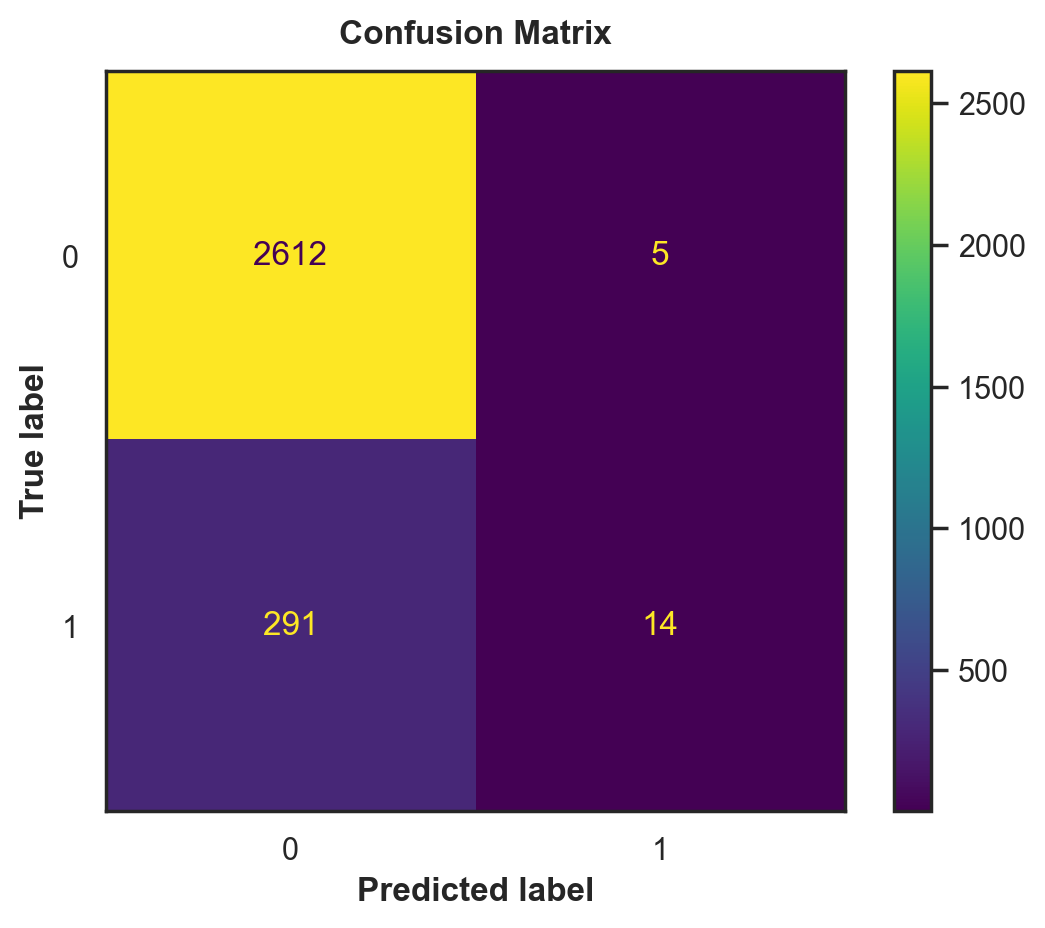

In [32]:
pipeline.plot_confusion_matrix()  # Plot the confusion matrix


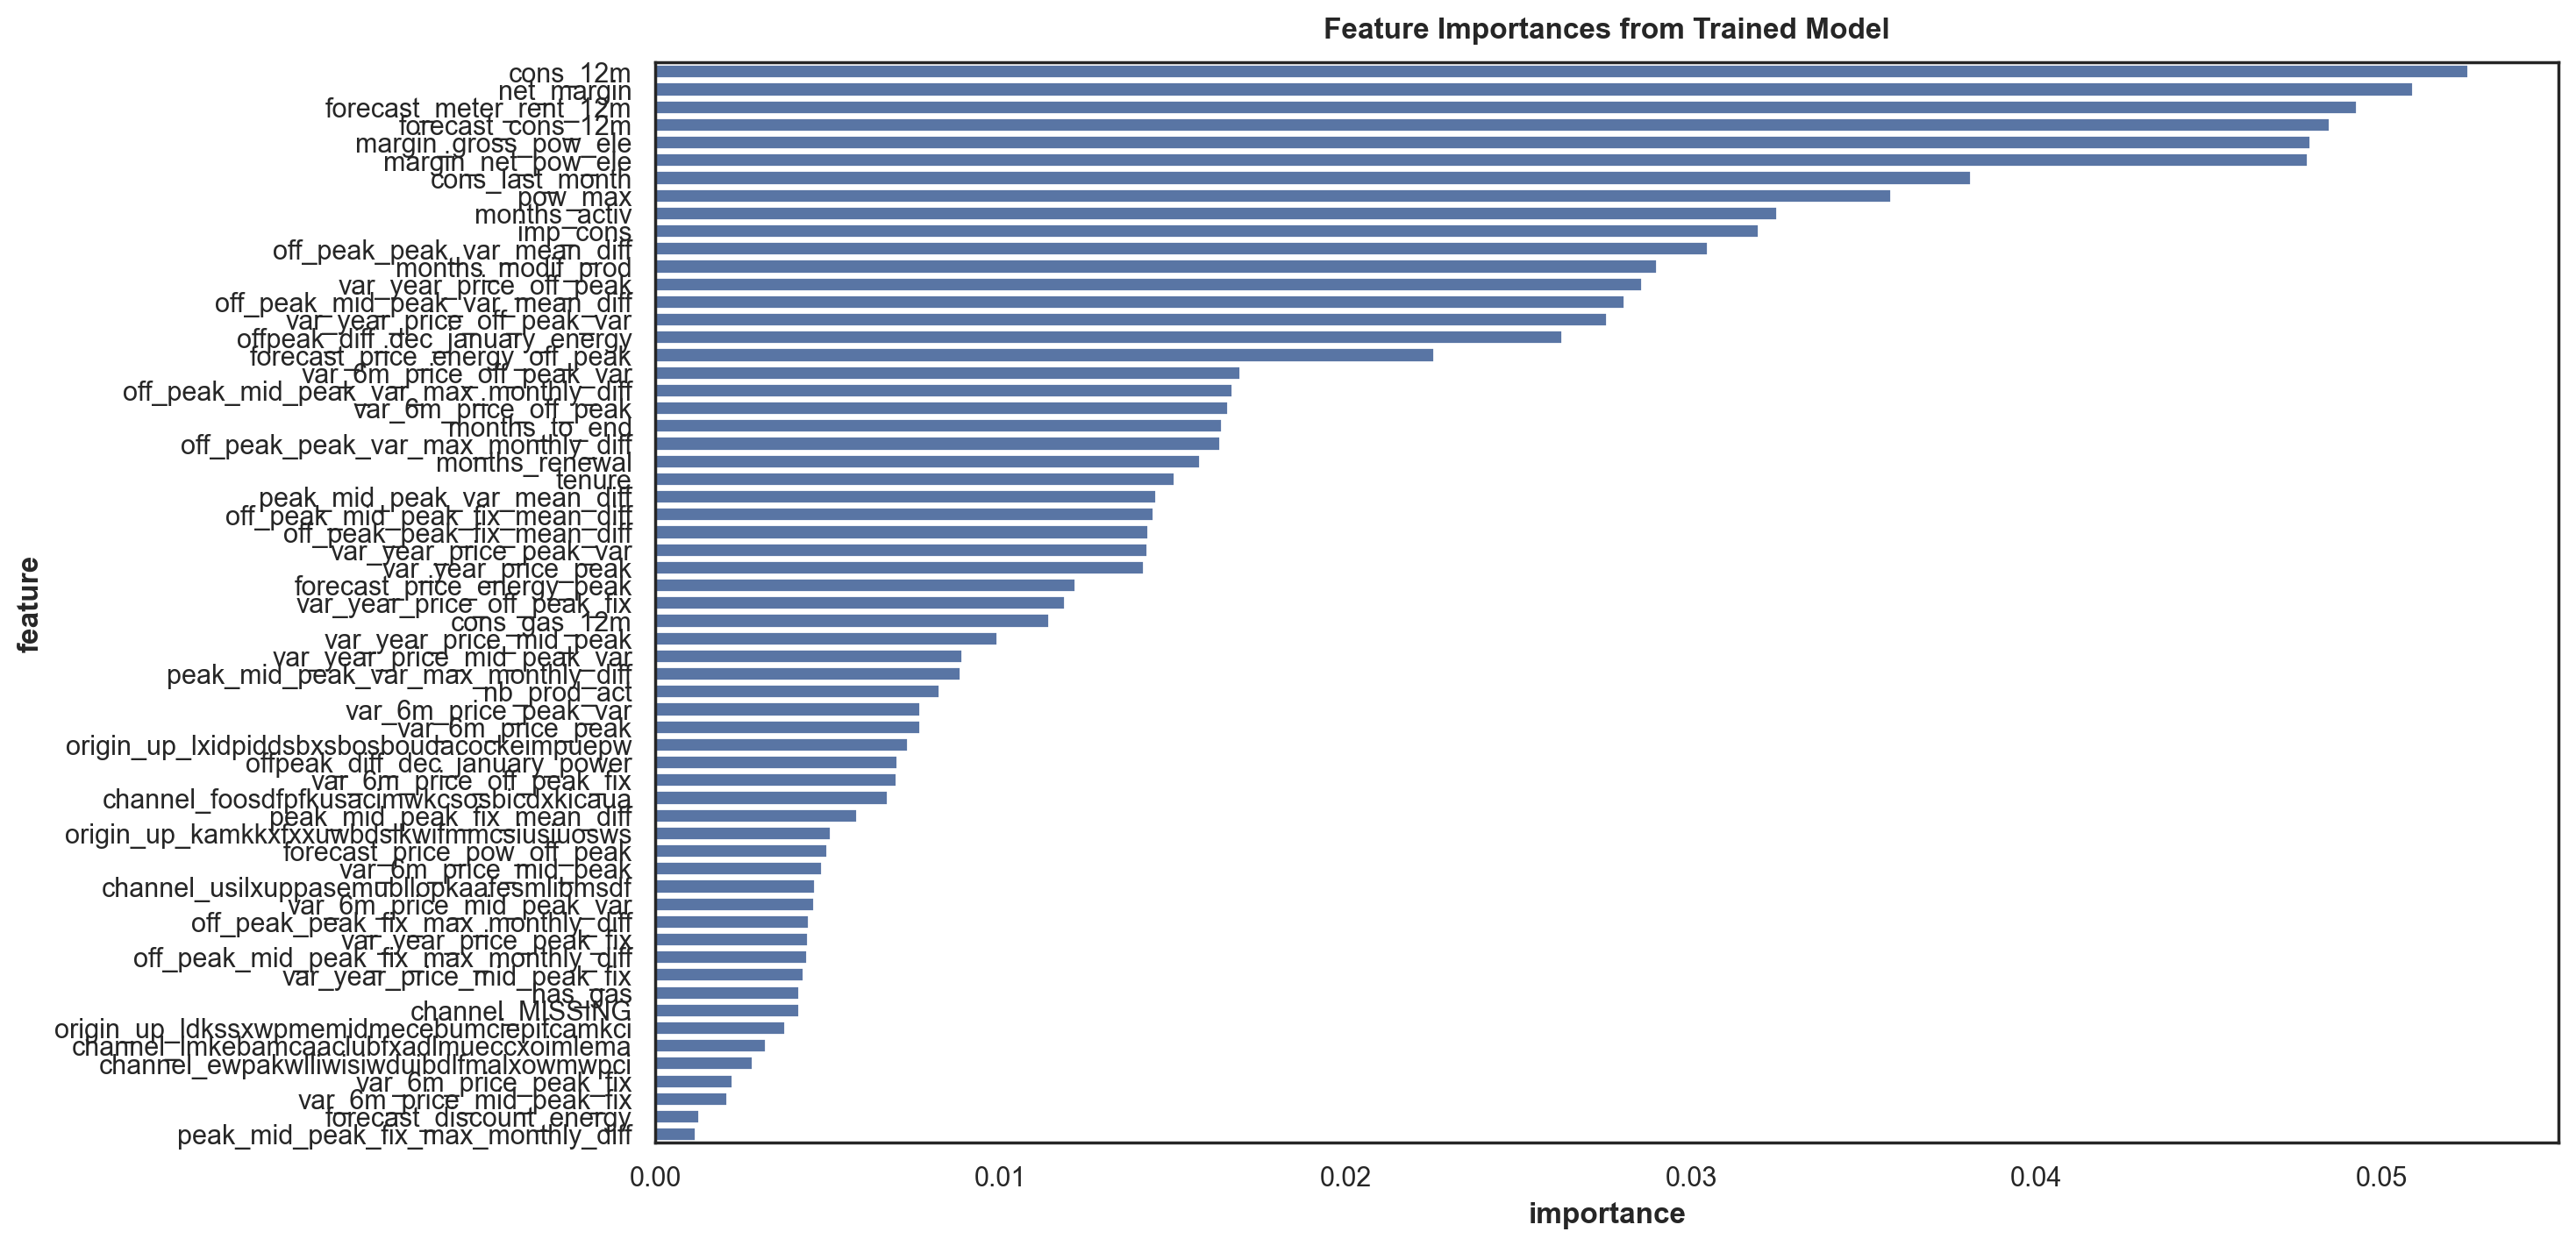

In [33]:
pipeline.visualize_study()      # Visualize the study and model feature importances

## `Optuna` Using `LightGBM`

In [72]:
import optuna
import lightgbm as lgb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

class ChurnPredictionPipelineGBM:
    def __init__(self, df, target_col, test_size=0.2, random_state=42):
        """
        Initialize the pipeline with the dataset and target column.
        """
        self.df = df
        self.target_col = target_col
        self.test_size = test_size
        self.random_state = random_state
        self.X_train, self.X_test, self.y_train, self.y_test = self._prepare_data()
        self.study = None
        self.final_model = None

    def _prepare_data(self):
        """
        Prepare the training and test sets.
        """
        X = self.df.drop(columns=[self.target_col, 'id']) if 'id' in self.df.columns.tolist() else self.df.drop(columns=[self.target_col])
        y = self.df[self.target_col]
        return train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)

    def objective(self, trial):
        """
        Objective function for Optuna to optimize hyperparameters.
        """

        n_estimators = trial.suggest_int("n_estimators", 150, 400)
        max_depth = trial.suggest_int("max_depth", 5, 15, log=True)
        learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1, log=True)
        num_leaves = trial.suggest_int("num_leaves", 31, 128)
        min_child_samples = trial.suggest_int("min_child_samples", 5, 100)  
        subsample = trial.suggest_float("subsample", 0.7, 1.0) 
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.7, 1.0) 
        random_state = 321

        # Instantiate LightGBM model with suggested hyperparameters
        model = lgb.LGBMClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            min_child_samples=min_child_samples,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            class_weight = 'balanced',
            random_state=random_state
        )

        # Perform cross-validation and return the mean accuracy score
        score = cross_val_score(model, self.X_train, self.y_train, cv=5, scoring="accuracy").mean()
        return score

    def optimize(self, n_trials=50):
        """
        Run the Optuna optimization.
        """
        self.study = optuna.create_study(direction="maximize")
        self.study.optimize(self.objective, n_trials=n_trials)
        print("Best hyperparameters:", self.study.best_params)

    def train_final_model(self):
        """
        Train the final model using the best parameters found by Optuna.
        """
        if self.study is None:
            raise ValueError("The study has not been optimized yet. Run the `optimize` method first.")
        
        best_params = self.study.best_params
        self.final_model = lgb.LGBMClassifier(
            n_estimators=best_params["n_estimators"],
            max_depth=best_params["max_depth"],
            learning_rate=best_params["learning_rate"],
            num_leaves=best_params["num_leaves"],
            min_child_samples=best_params["min_child_samples"],
            subsample=best_params["subsample"],
            colsample_bytree=best_params["colsample_bytree"],
            random_state=self.random_state
        )
        self.final_model.fit(self.X_train, self.y_train)

    def evaluate_model(self):
        """
        Evaluate the trained model on the test set and print the accuracy and additional metrics.
        """
        y_pred = self.final_model.predict(self.X_test)
        accuracy = accuracy_score(self.y_test, y_pred)
        print("Test set accuracy:", accuracy)

        # Display classification report
        print("Classification Report:")
        print(classification_report(self.y_test, y_pred))

        # Display precision-recall and ROC curves
        from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, roc_curve


        # Precision-recall curve
        precision, recall, _ = precision_recall_curve(self.y_test, self.final_model.predict_proba(self.X_test)[:, 1])
        pr_auc = auc(recall, precision)
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()
        plt.show()

        # ROC curve
        fpr, tpr, _ = roc_curve(self.y_test, self.final_model.predict_proba(self.X_test)[:, 1])
        roc_auc = roc_auc_score(self.y_test, self.final_model.predict_proba(self.X_test)[:, 1])
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()

    def plot_confusion_matrix(self):
        """
        Plot the confusion matrix for the model's performance on the test set.
        """
        sns.set_theme(context='notebook', style='white')
        if self.final_model is None:
            raise ValueError("The final model has not been trained yet. Run the `train_final_model` method first.")
        
        y_pred = self.final_model.predict(self.X_test)
        cm = confusion_matrix(self.y_test, y_pred)
        
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.final_model.classes_)
        disp.plot(cmap='viridis', values_format='d')
        plt.title('Confusion Matrix')
        plt.show()

    def visualize_study(self):
        """
        Visualize the optimization study to understand hyperparameter distributions and results.
        """
        if self.study is None:
            raise ValueError("The study has not been optimized yet. Run the `optimize` method first.")
                
        # Plot the optimization history (value of the objective function over trials)
        optuna.visualization.plot_optimization_history(self.study).show()
        # Plot the parameter importance
        optuna.visualization.plot_param_importances(self.study).show()

        # Show feature importances if the model is trained
        if self.final_model is not None:
            importances = self.final_model.feature_importances_
            feature_importances_df = pd.DataFrame({
                'feature': self.X_train.columns,
                'importance': importances
            }).sort_values(by='importance', ascending=False)

            plt.figure(figsize=(14, 8))
            sns.barplot(x='importance', y='feature', data=feature_importances_df)
            plt.title('Feature Importances from Trained Model')


In [73]:
pipeline_gbm = ChurnPredictionPipelineGBM(df, target_col='churn')


In [74]:
pipeline_gbm.optimize(n_trials=30)  


[I 2024-11-29 16:48:31,165] A new study created in memory with name: no-name-f12d1823-1634-477c-bfe1-b04ea3c34ac6


[LightGBM] [Info] Number of positive: 891, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9459
[LightGBM] [Info] Number of data points in the train set: 9347, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-11-29 16:48:36,137] Trial 0 finished with value: 0.8425204131277073 and parameters: {'n_estimators': 221, 'max_depth': 13, 'learning_rate': 0.020141397124300832, 'num_leaves': 70, 'min_child_samples': 33, 'subsample': 0.8404685461164039, 'colsample_bytree': 0.7397636354281024}. Best is trial 0 with value: 0.8425204131277073.


[LightGBM] [Info] Number of positive: 891, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9459
[LightGBM] [Info] Number of data points in the train set: 9347, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-11-29 16:48:44,875] Trial 1 finished with value: 0.8633178073399336 and parameters: {'n_estimators': 386, 'max_depth': 10, 'learning_rate': 0.010977526888958153, 'num_leaves': 107, 'min_child_samples': 11, 'subsample': 0.8574368668618337, 'colsample_bytree': 0.7979486368745684}. Best is trial 1 with value: 0.8633178073399336.


[LightGBM] [Info] Number of positive: 891, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9459
[LightGBM] [Info] Number of data points in the train set: 9347, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 891, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9463
[LightGBM] [Info] Numbe

[I 2024-11-29 16:48:48,598] Trial 2 finished with value: 0.8642590019988161 and parameters: {'n_estimators': 291, 'max_depth': 13, 'learning_rate': 0.03206690946962313, 'num_leaves': 49, 'min_child_samples': 30, 'subsample': 0.7070690077119168, 'colsample_bytree': 0.9839104607277189}. Best is trial 2 with value: 0.8642590019988161.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 891, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9459
[LightGBM] [Info] Number of data points in the train set: 9347, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-11-29 16:48:50,211] Trial 3 finished with value: 0.7469197498842328 and parameters: {'n_estimators': 230, 'max_depth': 5, 'learning_rate': 0.019882377333829228, 'num_leaves': 73, 'min_child_samples': 6, 'subsample': 0.8975844322913256, 'colsample_bytree': 0.9179725574070439}. Best is trial 2 with value: 0.8642590019988161.


[LightGBM] [Info] Number of positive: 891, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9459
[LightGBM] [Info] Number of data points in the train set: 9347, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-11-29 16:48:51,503] Trial 4 finished with value: 0.7068635661572911 and parameters: {'n_estimators': 170, 'max_depth': 5, 'learning_rate': 0.012150487213221385, 'num_leaves': 91, 'min_child_samples': 86, 'subsample': 0.7350226542292233, 'colsample_bytree': 0.874674136357303}. Best is trial 2 with value: 0.8642590019988161.


[LightGBM] [Info] Number of positive: 892, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9495
[LightGBM] [Info] Number of data points in the train set: 9348, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-11-29 16:48:53,262] Trial 5 finished with value: 0.7153370290912715 and parameters: {'n_estimators': 271, 'max_depth': 5, 'learning_rate': 0.010879449232609915, 'num_leaves': 107, 'min_child_samples': 37, 'subsample': 0.7184135695784329, 'colsample_bytree': 0.9056122496402015}. Best is trial 2 with value: 0.8642590019988161.


[LightGBM] [Info] Number of positive: 891, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9459
[LightGBM] [Info] Number of data points in the train set: 9347, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-11-29 16:48:55,862] Trial 6 finished with value: 0.8347314787134893 and parameters: {'n_estimators': 179, 'max_depth': 7, 'learning_rate': 0.03499406224854066, 'num_leaves': 120, 'min_child_samples': 5, 'subsample': 0.9205175969147447, 'colsample_bytree': 0.7068769800811332}. Best is trial 2 with value: 0.8642590019988161.


[LightGBM] [Info] Number of positive: 891, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9459
[LightGBM] [Info] Number of data points in the train set: 9347, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-11-29 16:48:59,219] Trial 7 finished with value: 0.836528508039226 and parameters: {'n_estimators': 174, 'max_depth': 12, 'learning_rate': 0.02672668034427948, 'num_leaves': 128, 'min_child_samples': 63, 'subsample': 0.734674672070485, 'colsample_bytree': 0.8386850453862}. Best is trial 2 with value: 0.8642590019988161.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 891, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9459
[LightGBM] [Info] Number of data points in the train set: 934

[I 2024-11-29 16:49:03,207] Trial 8 finished with value: 0.8965250057150896 and parameters: {'n_estimators': 312, 'max_depth': 15, 'learning_rate': 0.08139147388127321, 'num_leaves': 57, 'min_child_samples': 54, 'subsample': 0.9549952000965434, 'colsample_bytree': 0.8059007119686581}. Best is trial 8 with value: 0.8965250057150896.


[LightGBM] [Info] Number of positive: 891, number of negative: 8456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9459
[LightGBM] [Info] Number of data points in the train set: 9347, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2024-11-29 16:49:05,346] Trial 9 finished with value: 0.8159879997772581 and parameters: {'n_estimators': 172, 'max_depth': 8, 'learning_rate': 0.02863510061970241, 'num_leaves': 55, 'min_child_samples': 34, 'subsample': 0.9015194150688945, 'colsample_bytree': 0.8572178769387742}. Best is trial 8 with value: 0.8965250057150896.


[LightGBM] [Info] Number of positive: 891, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9459
[LightGBM] [Info] Number of data points in the train set: 9347, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-11-29 16:49:08,595] Trial 10 finished with value: 0.8811195420894368 and parameters: {'n_estimators': 365, 'max_depth': 15, 'learning_rate': 0.088549569871915, 'num_leaves': 33, 'min_child_samples': 100, 'subsample': 0.994233899865952, 'colsample_bytree': 0.7873983430048848}. Best is trial 8 with value: 0.8965250057150896.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 891, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9459
[LightGBM] [Info] Number of data points in the train set: 9347, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-11-29 16:49:11,996] Trial 11 finished with value: 0.8879664026002192 and parameters: {'n_estimators': 369, 'max_depth': 15, 'learning_rate': 0.09917215658194233, 'num_leaves': 35, 'min_child_samples': 100, 'subsample': 0.998654782157744, 'colsample_bytree': 0.7789421416052797}. Best is trial 8 with value: 0.8965250057150896.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 891, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9459
[LightGBM] [Info] Number of data points in the train set: 9347, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-11-29 16:49:14,817] Trial 12 finished with value: 0.8842859581714058 and parameters: {'n_estimators': 338, 'max_depth': 15, 'learning_rate': 0.09332966105055325, 'num_leaves': 31, 'min_child_samples': 68, 'subsample': 0.9959271183342815, 'colsample_bytree': 0.7829406761578783}. Best is trial 8 with value: 0.8965250057150896.


[LightGBM] [Info] Number of positive: 891, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9459
[LightGBM] [Info] Number of data points in the train set: 9347, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-11-29 16:49:18,039] Trial 13 finished with value: 0.8708494894519963 and parameters: {'n_estimators': 328, 'max_depth': 10, 'learning_rate': 0.05844067667113341, 'num_leaves': 51, 'min_child_samples': 81, 'subsample': 0.9625081956515384, 'colsample_bytree': 0.7483899446714648}. Best is trial 8 with value: 0.8965250057150896.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-29 16:49:22,893] Trial 14 finished with value: 0.8943002239142794 and parameters: {'n_estimators': 400, 'max_depth': 11, 'learning_rate': 0.06166004056483961, 'num_leaves': 61, 'min_child_samples': 50, 'subsample': 0.9452895032744978, 'colsample_bytree': 0.826839323832157}. Best is trial 8 with value: 0.8965250057150896.


[LightGBM] [Info] Number of positive: 891, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9459
[LightGBM] [Info] Number of data points in the train set: 9347, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-11-29 16:49:28,089] Trial 15 finished with value: 0.8915610107795381 and parameters: {'n_estimators': 400, 'max_depth': 11, 'learning_rate': 0.05569576470617275, 'num_leaves': 63, 'min_child_samples': 50, 'subsample': 0.9457878800264671, 'colsample_bytree': 0.8328808209454821}. Best is trial 8 with value: 0.8965250057150896.


[LightGBM] [Info] Number of positive: 891, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9459
[LightGBM] [Info] Number of data points in the train set: 9347, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-11-29 16:49:31,817] Trial 16 finished with value: 0.8847142601743249 and parameters: {'n_estimators': 310, 'max_depth': 9, 'learning_rate': 0.06591231838802403, 'num_leaves': 87, 'min_child_samples': 51, 'subsample': 0.8041995328477164, 'colsample_bytree': 0.8237097954801322}. Best is trial 8 with value: 0.8965250057150896.


[LightGBM] [Info] Number of positive: 891, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9459
[LightGBM] [Info] Number of data points in the train set: 9347, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-11-29 16:49:34,114] Trial 17 finished with value: 0.8370416205063277 and parameters: {'n_estimators': 259, 'max_depth': 7, 'learning_rate': 0.04538205838788452, 'num_leaves': 83, 'min_child_samples': 63, 'subsample': 0.9423380202059345, 'colsample_bytree': 0.8920685514893164}. Best is trial 8 with value: 0.8965250057150896.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-29 16:49:39,063] Trial 18 finished with value: 0.8958405504657065 and parameters: {'n_estimators': 349, 'max_depth': 12, 'learning_rate': 0.07101756785704759, 'num_leaves': 62, 'min_child_samples': 46, 'subsample': 0.8680232326840011, 'colsample_bytree': 0.9453140906358913}. Best is trial 8 with value: 0.8965250057150896.


[LightGBM] [Info] Number of positive: 891, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9459
[LightGBM] [Info] Number of data points in the train set: 9347, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-11-29 16:49:43,214] Trial 19 finished with value: 0.8878808227970527 and parameters: {'n_estimators': 346, 'max_depth': 13, 'learning_rate': 0.07213185600385574, 'num_leaves': 44, 'min_child_samples': 74, 'subsample': 0.7919483912740279, 'colsample_bytree': 0.9508536294811682}. Best is trial 8 with value: 0.8965250057150896.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 891, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9459
[LightGBM] [Info] Number of data points in the train set: 9347, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-11-29 16:49:47,834] Trial 20 finished with value: 0.878637178269764 and parameters: {'n_estimators': 301, 'max_depth': 8, 'learning_rate': 0.045747902812428486, 'num_leaves': 74, 'min_child_samples': 16, 'subsample': 0.860896125220906, 'colsample_bytree': 0.989131520981171}. Best is trial 8 with value: 0.8965250057150896.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 891, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9459
[LightGBM] [Info] Number of data points in the train set: 9347, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-11-29 16:49:52,619] Trial 21 finished with value: 0.8976379461433404 and parameters: {'n_estimators': 363, 'max_depth': 11, 'learning_rate': 0.076593607120288, 'num_leaves': 61, 'min_child_samples': 45, 'subsample': 0.8990907702659404, 'colsample_bytree': 0.8189791613954005}. Best is trial 21 with value: 0.8976379461433404.


[LightGBM] [Info] Number of positive: 891, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9459
[LightGBM] [Info] Number of data points in the train set: 9347, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-11-29 16:49:58,277] Trial 22 finished with value: 0.8991782360595776 and parameters: {'n_estimators': 360, 'max_depth': 12, 'learning_rate': 0.07444569204389222, 'num_leaves': 63, 'min_child_samples': 41, 'subsample': 0.8836701539684303, 'colsample_bytree': 0.9445740972228048}. Best is trial 22 with value: 0.8991782360595776.


[LightGBM] [Info] Number of positive: 891, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9459
[LightGBM] [Info] Number of data points in the train set: 9347, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 891, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9463
[LightGBM] [Info] Number of data points in the train set: 9347, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number

[I 2024-11-29 16:50:02,370] Trial 23 finished with value: 0.8984080544662693 and parameters: {'n_estimators': 322, 'max_depth': 14, 'learning_rate': 0.08185126459996075, 'num_leaves': 45, 'min_child_samples': 21, 'subsample': 0.8883151407904516, 'colsample_bytree': 0.8720749677829698}. Best is trial 22 with value: 0.8991782360595776.


[LightGBM] [Info] Number of positive: 891, number of negative: 8456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9459
[LightGBM] [Info] Number of data points in the train set: 9347, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2024-11-29 16:50:06,897] Trial 24 finished with value: 0.8859124506890346 and parameters: {'n_estimators': 370, 'max_depth': 10, 'learning_rate': 0.046814132512707086, 'num_leaves': 44, 'min_child_samples': 22, 'subsample': 0.890383299174421, 'colsample_bytree': 0.9418448381341125}. Best is trial 22 with value: 0.8991782360595776.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 891, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9459
[LightGBM] [Info] Number of data points in the train set: 9347, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-11-29 16:50:10,382] Trial 25 finished with value: 0.8907908658214196 and parameters: {'n_estimators': 320, 'max_depth': 12, 'learning_rate': 0.07738873438654945, 'num_leaves': 40, 'min_child_samples': 25, 'subsample': 0.8217967772407294, 'colsample_bytree': 0.8657184245222317}. Best is trial 22 with value: 0.8991782360595776.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 891, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9459
[LightGBM] [Info] Number of data points in the train set: 9347, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-11-29 16:50:15,059] Trial 26 finished with value: 0.8891648861964466 and parameters: {'n_estimators': 355, 'max_depth': 9, 'learning_rate': 0.0564611536069811, 'num_leaves': 96, 'min_child_samples': 41, 'subsample': 0.916803404541801, 'colsample_bytree': 0.8872639329572235}. Best is trial 22 with value: 0.8991782360595776.


[LightGBM] [Info] Number of positive: 891, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9459
[LightGBM] [Info] Number of data points in the train set: 9347, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 891, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002325 seconds.
You can set `force_col_wise=true` to rem

[I 2024-11-29 16:50:20,335] Trial 27 finished with value: 0.8881377453825007 and parameters: {'n_estimators': 286, 'max_depth': 14, 'learning_rate': 0.03893236517908341, 'num_leaves': 70, 'min_child_samples': 19, 'subsample': 0.8719940816531278, 'colsample_bytree': 0.9264361734027389}. Best is trial 22 with value: 0.8991782360595776.


[LightGBM] [Info] Number of positive: 891, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9459
[LightGBM] [Info] Number of data points in the train set: 9347, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-11-29 16:50:27,342] Trial 28 finished with value: 0.9048271991371679 and parameters: {'n_estimators': 380, 'max_depth': 11, 'learning_rate': 0.0816570322337195, 'num_leaves': 77, 'min_child_samples': 27, 'subsample': 0.8309207851587919, 'colsample_bytree': 0.9764720016491535}. Best is trial 28 with value: 0.9048271991371679.


[LightGBM] [Info] Number of positive: 891, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9459
[LightGBM] [Info] Number of data points in the train set: 9347, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2024-11-29 16:50:34,455] Trial 29 finished with value: 0.8739308752586444 and parameters: {'n_estimators': 385, 'max_depth': 13, 'learning_rate': 0.02044083494053584, 'num_leaves': 68, 'min_child_samples': 26, 'subsample': 0.8259837624291368, 'colsample_bytree': 0.9690688569727725}. Best is trial 28 with value: 0.9048271991371679.


Best hyperparameters: {'n_estimators': 380, 'max_depth': 11, 'learning_rate': 0.0816570322337195, 'num_leaves': 77, 'min_child_samples': 27, 'subsample': 0.8309207851587919, 'colsample_bytree': 0.9764720016491535}


In [75]:
pipeline_gbm.train_final_model()    # Train the final model with the best parameters


[LightGBM] [Info] Number of positive: 1114, number of negative: 10570
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9573
[LightGBM] [Info] Number of data points in the train set: 11684, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.095344 -> initscore=-2.250063
[LightGBM] [Info] Start training from score -2.250063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

Test set accuracy: 0.9062286105407256
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2617
           1       0.74      0.16      0.26       305

    accuracy                           0.91      2922
   macro avg       0.82      0.58      0.60      2922
weighted avg       0.89      0.91      0.88      2922



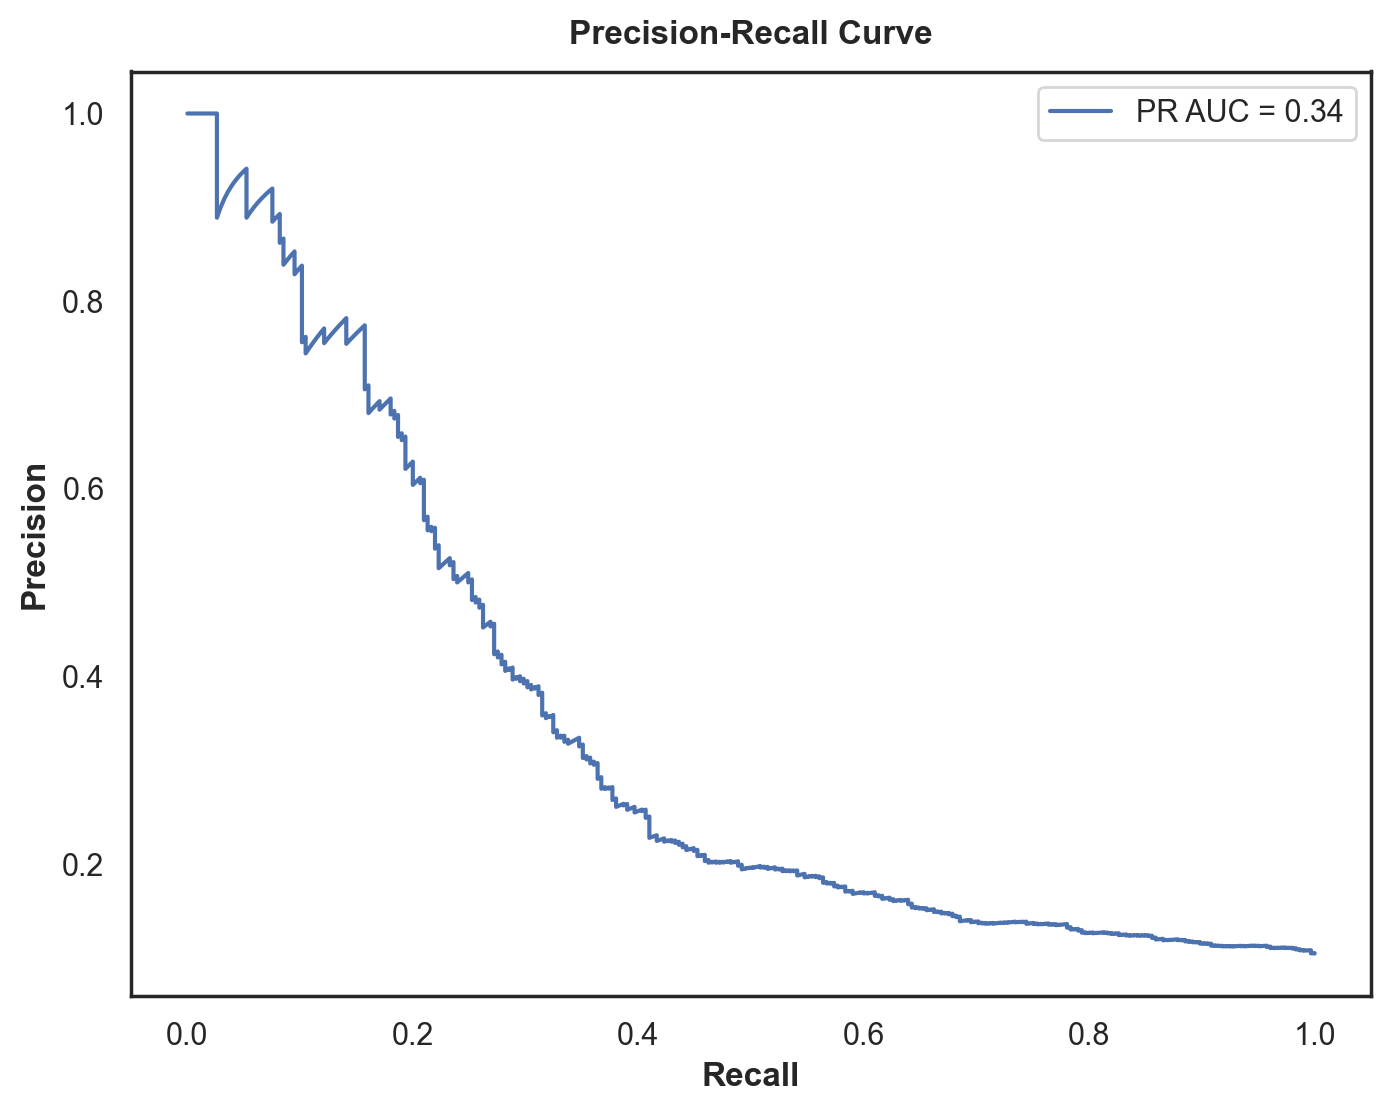

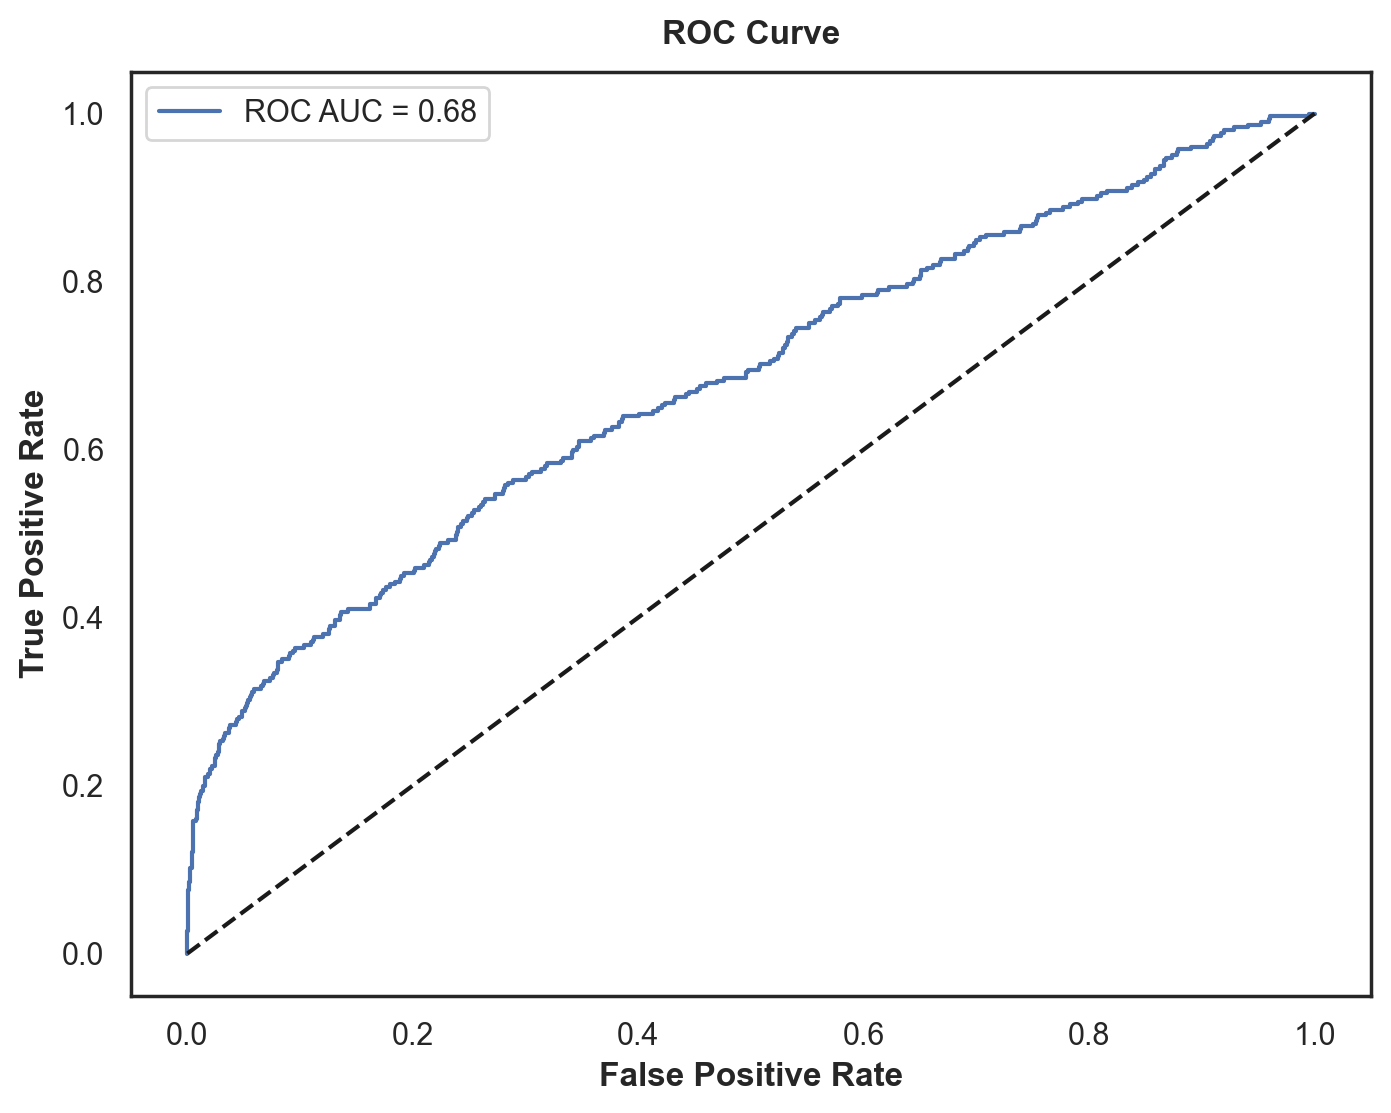

In [76]:
pipeline_gbm.evaluate_model()       # Evaluate the model on the test set


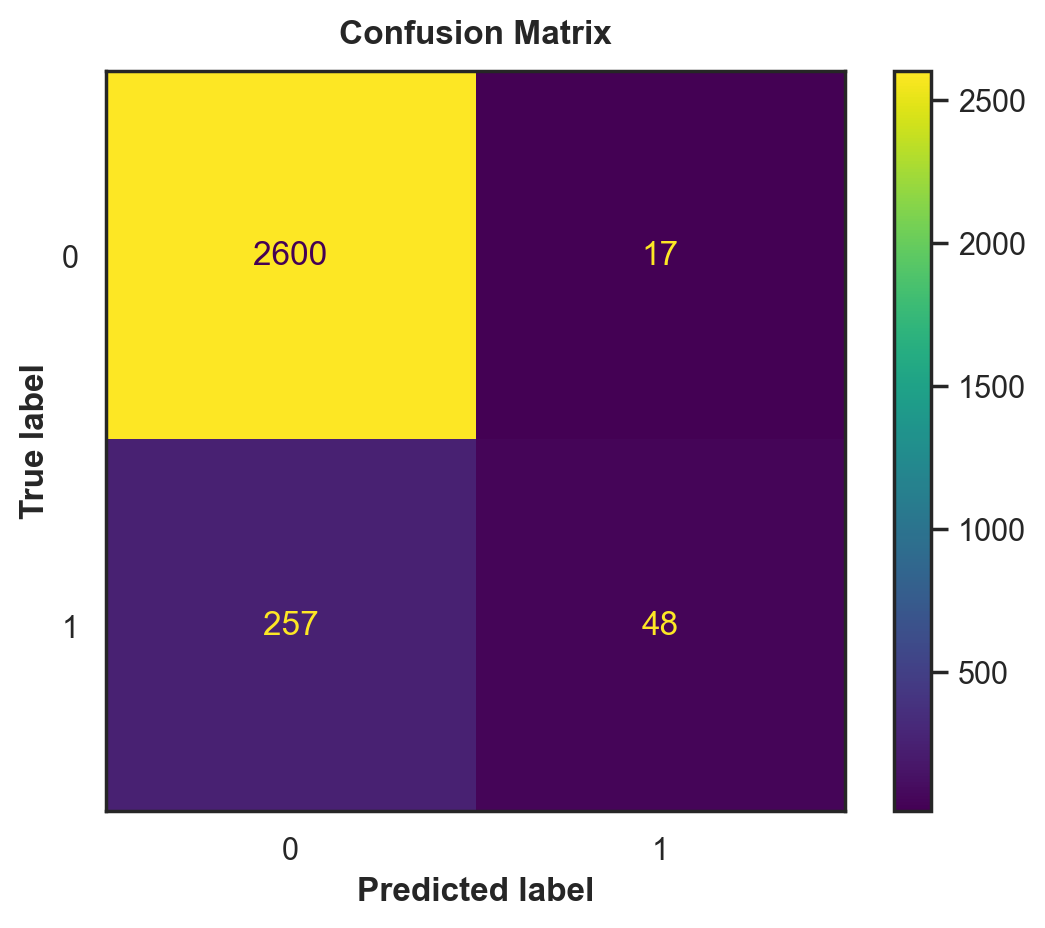

In [77]:
pipeline_gbm.plot_confusion_matrix()  # Plot the confusion matrix


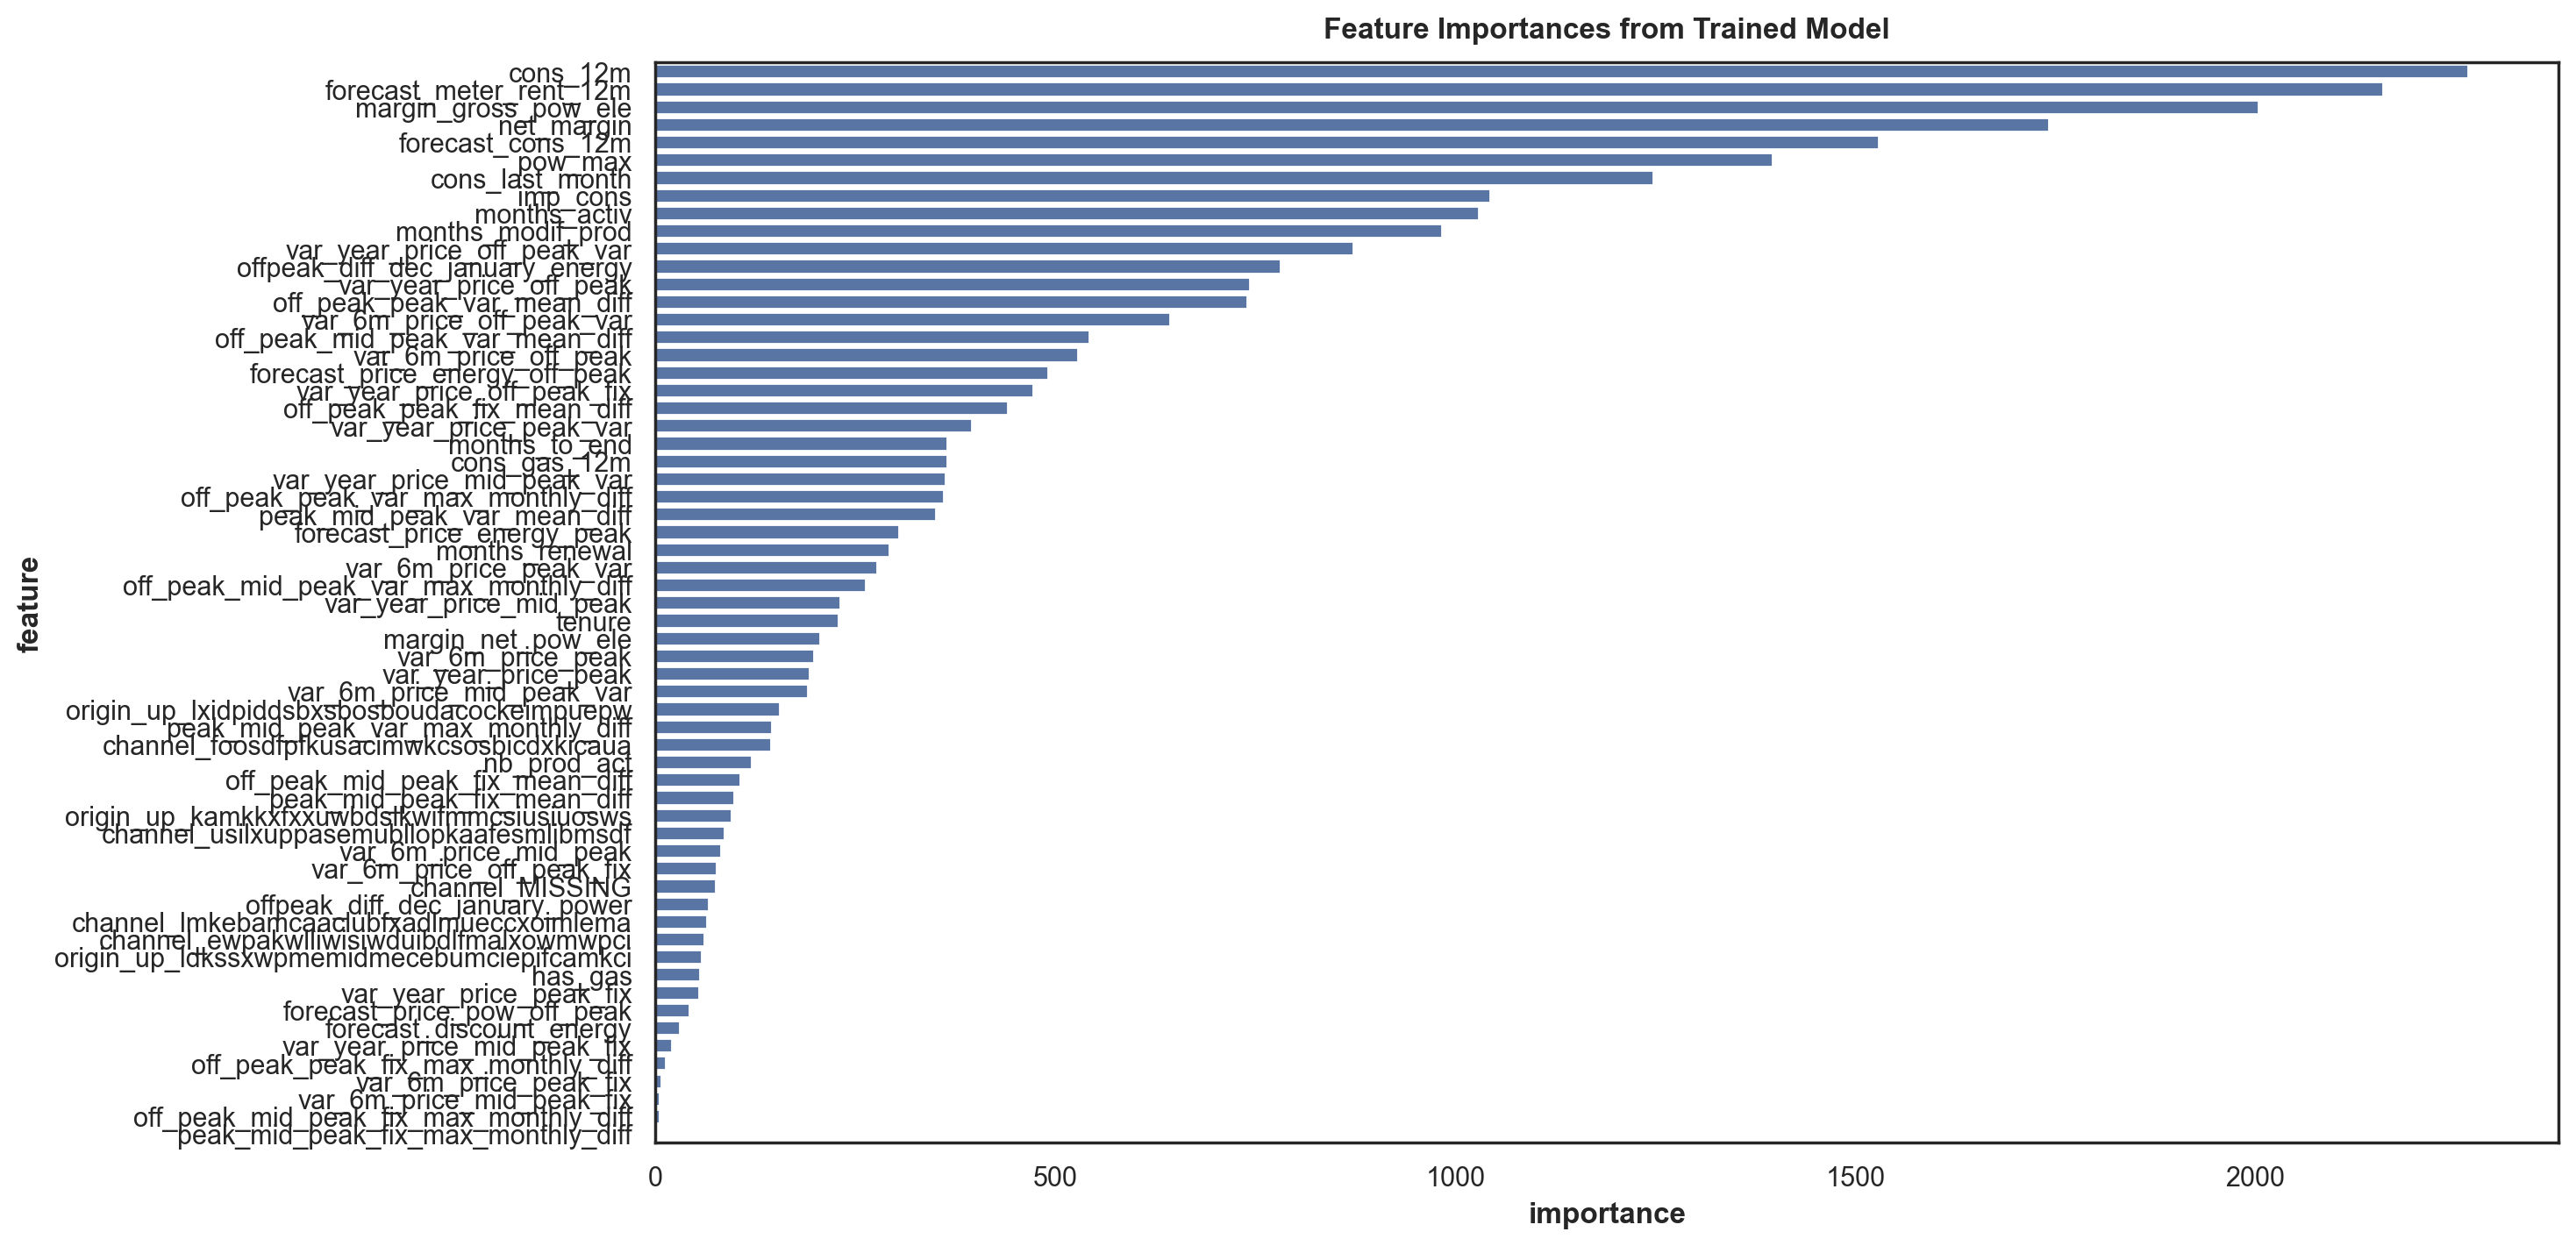

In [78]:
pipeline_gbm.visualize_study()

# Will continue from here
---

## `LightGBM` with `SMOTE` Oversampling

In [45]:
import optuna
import lightgbm as lgb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

class ChurnPredictionPipelineGBM_SMOTE:
    def __init__(self, df, target_col, test_size=0.2, random_state=42):
        """
        Initialize the pipeline with the dataset and target column.
        """
        self.df = df
        self.target_col = target_col
        self.test_size = test_size
        self.random_state = random_state
        self.X_train, self.X_test, self.y_train, self.y_test = self._prepare_data()
        self.study = None
        self.final_model = None

    def _prepare_data(self):
        """
        Prepare the training and test sets and apply SMOTE for oversampling the minority class.
        """
        X = self.df.drop(columns=[self.target_col, 'id']) if 'id' in self.df.columns.tolist() else self.df.drop(columns=[self.target_col])
        y = self.df[self.target_col]
        
        # Split the data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)

        # Apply SMOTE to the training set to balance the classes
        smote = SMOTE(random_state=self.random_state)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

        # Return the resampled training set and the original test set
        return X_train_resampled, X_test, y_train_resampled, y_test

    def objective(self, trial):
        """
        Objective function for Optuna to optimize hyperparameters.
        """
        n_estimators = trial.suggest_int("n_estimators", 150, 400)
        max_depth = trial.suggest_int("max_depth", 5, 15, log=True)
        learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1, log=True)
        num_leaves = trial.suggest_int("num_leaves", 31, 128)
        min_child_samples = trial.suggest_int("min_child_samples", 5, 100)  
        subsample = trial.suggest_float("subsample", 0.7, 1.0) 
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.7, 1.0) 
        random_state = 321

        # Instantiate LightGBM model with suggested hyperparameters
        model = lgb.LGBMClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            min_child_samples=min_child_samples,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            random_state=random_state
        )

        # Perform cross-validation and return the mean accuracy score
        score = cross_val_score(model, self.X_train, self.y_train, cv=5, scoring="accuracy").mean()
        return score

    def optimize(self, n_trials=50):
        """
        Run the Optuna optimization.
        """
        self.study = optuna.create_study(direction="maximize")
        self.study.optimize(self.objective, n_trials=n_trials)
        print("Best hyperparameters:", self.study.best_params)

    def train_final_model(self):
        """
        Train the final model using the best parameters found by Optuna.
        """
        if self.study is None:
            raise ValueError("The study has not been optimized yet. Run the `optimize` method first.")
        
        best_params = self.study.best_params
        self.final_model = lgb.LGBMClassifier(
            n_estimators=best_params["n_estimators"],
            max_depth=best_params["max_depth"],
            learning_rate=best_params["learning_rate"],
            num_leaves=best_params["num_leaves"],
            min_child_samples=best_params["min_child_samples"],
            subsample=best_params["subsample"],
            colsample_bytree=best_params["colsample_bytree"],
            random_state=self.random_state
        )
        self.final_model.fit(self.X_train, self.y_train)

    def evaluate_model(self):
        """
        Evaluate the trained model on the test set and print the accuracy.
        """
        y_pred = self.final_model.predict(self.X_test)
        accuracy = accuracy_score(self.y_test, y_pred)
        print("Test set accuracy:", accuracy)

        print(classification_report(self.y_test, y_pred))

    def plot_confusion_matrix(self):
        """
        Plot the confusion matrix for the model's performance on the test set.
        """
        sns.set_theme(context='notebook', style='white')
        if self.final_model is None:
            raise ValueError("The final model has not been trained yet. Run the `train_final_model` method first.")
        
        y_pred = self.final_model.predict(self.X_test)
        cm = confusion_matrix(self.y_test, y_pred)
        
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.final_model.classes_)
        disp.plot(cmap='viridis', values_format='d')
        plt.title('Confusion Matrix')
        plt.show()

    def visualize_study(self):
        """
        Visualize the optimization study to understand hyperparameter distributions and results.
        """
        if self.study is None:
            raise ValueError("The study has not been optimized yet. Run the `optimize` method first.")
                
        # Plot the optimization history (value of the objective function over trials)
        optuna.visualization.plot_optimization_history(self.study).show()
        # Plot the parameter importance
        optuna.visualization.plot_param_importances(self.study).show()

        # Show feature importances if the model is trained
        if self.final_model is not None:
            importances = self.final_model.feature_importances_
            feature_importances_df = pd.DataFrame({
                'feature': self.X_train.columns,
                'importance': importances
            }).sort_values(by='importance', ascending=False)

            plt.figure(figsize=(14, 8))
            sns.barplot(x='importance', y='feature', data=feature_importances_df)
            plt.title('Feature Importances from Trained Model')


In [46]:
pipeline_SMOTE = ChurnPredictionPipelineGBM_SMOTE(df, target_col='churn')

In [49]:
pipeline_SMOTE.optimize(n_trials=50)  # Run the optimization with 50 trials


[I 2024-11-29 16:09:48,997] A new study created in memory with name: no-name-06493fa5-88f0-4865-a595-d3a812ea4ce7


[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2024-11-29 16:09:57,833] Trial 0 finished with value: 0.9420529801324504 and parameters: {'n_estimators': 282, 'max_depth': 7, 'learning_rate': 0.07046251752168546, 'num_leaves': 111, 'min_child_samples': 71, 'subsample': 0.7577747665322424, 'colsample_bytree': 0.9483230565069973}. Best is trial 0 with value: 0.9420529801324504.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]

[I 2024-11-29 16:10:02,893] Trial 1 finished with value: 0.9441343424787135 and parameters: {'n_estimators': 307, 'max_depth': 12, 'learning_rate': 0.04389573689818369, 'num_leaves': 47, 'min_child_samples': 23, 'subsample': 0.8635012382807061, 'colsample_bytree': 0.7125898790296011}. Best is trial 1 with value: 0.9441343424787135.


[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12053
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threadin

[I 2024-11-29 16:10:07,599] Trial 2 finished with value: 0.9254020813623463 and parameters: {'n_estimators': 295, 'max_depth': 9, 'learning_rate': 0.013652113759445436, 'num_leaves': 48, 'min_child_samples': 41, 'subsample': 0.9244285872908217, 'colsample_bytree': 0.7793478964138533}. Best is trial 1 with value: 0.9441343424787135.


[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2024-11-29 16:10:09,610] Trial 3 finished with value: 0.9205771050141911 and parameters: {'n_estimators': 205, 'max_depth': 5, 'learning_rate': 0.030291255704532515, 'num_leaves': 92, 'min_child_samples': 63, 'subsample': 0.8893295527995997, 'colsample_bytree': 0.9414005133266213}. Best is trial 1 with value: 0.9441343424787135.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-29 16:10:13,892] Trial 4 finished with value: 0.9202459791863765 and parameters: {'n_estimators': 158, 'max_depth': 10, 'learning_rate': 0.016950590883601457, 'num_leaves': 97, 'min_child_samples': 72, 'subsample': 0.9685832428370786, 'colsample_bytree': 0.8091616672883934}. Best is trial 1 with value: 0.9441343424787135.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2024-11-29 16:10:20,611] Trial 5 finished with value: 0.9447492904446546 and parameters: {'n_estimators': 343, 'max_depth': 7, 'learning_rate': 0.05496507744741391, 'num_leaves': 75, 'min_child_samples': 8, 'subsample': 0.9953130401063386, 'colsample_bytree': 0.9733098704847418}. Best is trial 5 with value: 0.9447492904446546.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number 

[I 2024-11-29 16:10:31,105] Trial 6 finished with value: 0.9438978240302743 and parameters: {'n_estimators': 305, 'max_depth': 15, 'learning_rate': 0.03285251757594598, 'num_leaves': 71, 'min_child_samples': 42, 'subsample': 0.7408070976918073, 'colsample_bytree': 0.8629596630967324}. Best is trial 5 with value: 0.9447492904446546.


[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12053
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2024-11-29 16:10:45,518] Trial 7 finished with value: 0.9385998107852412 and parameters: {'n_estimators': 322, 'max_depth': 13, 'learning_rate': 0.01601406978528156, 'num_leaves': 108, 'min_child_samples': 49, 'subsample': 0.9540849789790404, 'colsample_bytree': 0.9937343553259872}. Best is trial 5 with value: 0.9447492904446546.


[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2024-11-29 16:10:49,786] Trial 8 finished with value: 0.9434720908230843 and parameters: {'n_estimators': 369, 'max_depth': 6, 'learning_rate': 0.09201948769779654, 'num_leaves': 120, 'min_child_samples': 52, 'subsample': 0.716269624910254, 'colsample_bytree': 0.9019594616294413}. Best is trial 5 with value: 0.9447492904446546.


[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2024-11-29 16:10:52,846] Trial 9 finished with value: 0.9385525070955534 and parameters: {'n_estimators': 196, 'max_depth': 8, 'learning_rate': 0.05124886109147847, 'num_leaves': 45, 'min_child_samples': 74, 'subsample': 0.7996466860642435, 'colsample_bytree': 0.9186808496237435}. Best is trial 5 with value: 0.9447492904446546.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-29 16:10:56,616] Trial 10 finished with value: 0.9283822138126775 and parameters: {'n_estimators': 389, 'max_depth': 5, 'learning_rate': 0.024681477630404295, 'num_leaves': 71, 'min_child_samples': 98, 'subsample': 0.994678166764448, 'colsample_bytree': 0.9963135299074299}. Best is trial 5 with value: 0.9447492904446546.


[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12053
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threadin

[I 2024-11-29 16:11:00,924] Trial 11 finished with value: 0.9423368022705771 and parameters: {'n_estimators': 345, 'max_depth': 11, 'learning_rate': 0.044877615974980474, 'num_leaves': 31, 'min_child_samples': 7, 'subsample': 0.8681283159934492, 'colsample_bytree': 0.7018064928290091}. Best is trial 5 with value: 0.9447492904446546.


[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive:

[I 2024-11-29 16:11:05,030] Trial 12 finished with value: 0.9424314096499528 and parameters: {'n_estimators': 248, 'max_depth': 7, 'learning_rate': 0.053937136486408035, 'num_leaves': 57, 'min_child_samples': 7, 'subsample': 0.8201539513146308, 'colsample_bytree': 0.7002451530749981}. Best is trial 5 with value: 0.9447492904446546.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12053
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500

[I 2024-11-29 16:11:14,192] Trial 13 finished with value: 0.9456007568590351 and parameters: {'n_estimators': 343, 'max_depth': 11, 'learning_rate': 0.03993727903096731, 'num_leaves': 83, 'min_child_samples': 24, 'subsample': 0.9101794787982307, 'colsample_bytree': 0.7623971664506926}. Best is trial 13 with value: 0.9456007568590351.


[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2024-11-29 16:11:22,587] Trial 14 finished with value: 0.9461210974456009 and parameters: {'n_estimators': 351, 'max_depth': 8, 'learning_rate': 0.0727016648704062, 'num_leaves': 82, 'min_child_samples': 20, 'subsample': 0.9188559714522185, 'colsample_bytree': 0.7666853908164691}. Best is trial 14 with value: 0.9461210974456009.


[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2024-11-29 16:11:32,741] Trial 15 finished with value: 0.9460264900662253 and parameters: {'n_estimators': 386, 'max_depth': 9, 'learning_rate': 0.09634088891251179, 'num_leaves': 87, 'min_child_samples': 27, 'subsample': 0.916217393833361, 'colsample_bytree': 0.7731919231323593}. Best is trial 14 with value: 0.9461210974456009.


[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2024-11-29 16:11:42,598] Trial 16 finished with value: 0.9458845789971617 and parameters: {'n_estimators': 399, 'max_depth': 9, 'learning_rate': 0.09329825434521724, 'num_leaves': 91, 'min_child_samples': 28, 'subsample': 0.9345434321070278, 'colsample_bytree': 0.8323600101638448}. Best is trial 14 with value: 0.9461210974456009.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2024-11-29 16:11:47,121] Trial 17 finished with value: 0.9451750236518448 and parameters: {'n_estimators': 256, 'max_depth': 8, 'learning_rate': 0.07302982393518129, 'num_leaves': 63, 'min_child_samples': 34, 'subsample': 0.8196403541450592, 'colsample_bytree': 0.7590641014846632}. Best is trial 14 with value: 0.9461210974456009.


[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2024-11-29 16:11:51,795] Trial 18 finished with value: 0.9438978240302743 and parameters: {'n_estimators': 370, 'max_depth': 6, 'learning_rate': 0.07118392876395985, 'num_leaves': 104, 'min_child_samples': 17, 'subsample': 0.9034884760101987, 'colsample_bytree': 0.7438190475596301}. Best is trial 14 with value: 0.9461210974456009.


[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2024-11-29 16:11:56,296] Trial 19 finished with value: 0.9441816461684012 and parameters: {'n_estimators': 372, 'max_depth': 6, 'learning_rate': 0.08666434067217631, 'num_leaves': 127, 'min_child_samples': 39, 'subsample': 0.9557607263275012, 'colsample_bytree': 0.8012281183575883}. Best is trial 14 with value: 0.9461210974456009.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-29 16:12:06,304] Trial 20 finished with value: 0.9262062440870388 and parameters: {'n_estimators': 326, 'max_depth': 9, 'learning_rate': 0.010185038751233994, 'num_leaves': 83, 'min_child_samples': 16, 'subsample': 0.8940361590256828, 'colsample_bytree': 0.8498307153549896}. Best is trial 14 with value: 0.9461210974456009.


[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2024-11-29 16:12:15,803] Trial 21 finished with value: 0.945600756859035 and parameters: {'n_estimators': 391, 'max_depth': 9, 'learning_rate': 0.09820192082405926, 'num_leaves': 89, 'min_child_samples': 29, 'subsample': 0.9294398296097091, 'colsample_bytree': 0.8316906735793125}. Best is trial 14 with value: 0.9461210974456009.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]

[I 2024-11-29 16:12:27,440] Trial 22 finished with value: 0.9470198675496689 and parameters: {'n_estimators': 397, 'max_depth': 10, 'learning_rate': 0.06842346074295488, 'num_leaves': 98, 'min_child_samples': 18, 'subsample': 0.9363682436260514, 'colsample_bytree': 0.7986367198404358}. Best is trial 22 with value: 0.9470198675496689.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12053
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with posit

[I 2024-11-29 16:12:39,082] Trial 23 finished with value: 0.9467360454115422 and parameters: {'n_estimators': 359, 'max_depth': 10, 'learning_rate': 0.06523456180349882, 'num_leaves': 98, 'min_child_samples': 17, 'subsample': 0.8775320732244812, 'colsample_bytree': 0.7864031289315623}. Best is trial 22 with value: 0.9470198675496689.


[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12053
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2024-11-29 16:12:50,398] Trial 24 finished with value: 0.9464995269631032 and parameters: {'n_estimators': 359, 'max_depth': 10, 'learning_rate': 0.06278752599406676, 'num_leaves': 101, 'min_child_samples': 16, 'subsample': 0.8357967598626929, 'colsample_bytree': 0.7326945503357146}. Best is trial 22 with value: 0.9470198675496689.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12053
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500

[I 2024-11-29 16:13:05,619] Trial 25 finished with value: 0.9473509933774835 and parameters: {'n_estimators': 369, 'max_depth': 13, 'learning_rate': 0.0596153217943717, 'num_leaves': 100, 'min_child_samples': 12, 'subsample': 0.8328741610654277, 'colsample_bytree': 0.7315716469002475}. Best is trial 25 with value: 0.9473509933774835.


[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12053
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threadin

[I 2024-11-29 16:13:23,221] Trial 26 finished with value: 0.9473509933774835 and parameters: {'n_estimators': 399, 'max_depth': 15, 'learning_rate': 0.03527334401588981, 'num_leaves': 112, 'min_child_samples': 11, 'subsample': 0.7789919266171601, 'colsample_bytree': 0.8001641149695377}. Best is trial 25 with value: 0.9473509933774835.


[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12053
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threadin

[I 2024-11-29 16:13:38,503] Trial 27 finished with value: 0.9468779564806056 and parameters: {'n_estimators': 398, 'max_depth': 15, 'learning_rate': 0.025873869251013943, 'num_leaves': 114, 'min_child_samples': 12, 'subsample': 0.7841755347066286, 'colsample_bytree': 0.7344390280158059}. Best is trial 25 with value: 0.9473509933774835.


[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2024-11-29 16:13:48,583] Trial 28 finished with value: 0.9444181646168401 and parameters: {'n_estimators': 377, 'max_depth': 13, 'learning_rate': 0.037007851398461966, 'num_leaves': 120, 'min_child_samples': 95, 'subsample': 0.783751611510845, 'colsample_bytree': 0.8760196885842628}. Best is trial 25 with value: 0.9473509933774835.


[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive:

[I 2024-11-29 16:13:57,491] Trial 29 finished with value: 0.9430936613055818 and parameters: {'n_estimators': 280, 'max_depth': 14, 'learning_rate': 0.024530039112891745, 'num_leaves': 111, 'min_child_samples': 62, 'subsample': 0.7445682205526758, 'colsample_bytree': 0.810036317853887}. Best is trial 25 with value: 0.9473509933774835.


[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2024-11-29 16:14:05,612] Trial 30 finished with value: 0.944938505203406 and parameters: {'n_estimators': 326, 'max_depth': 12, 'learning_rate': 0.04762312154792366, 'num_leaves': 117, 'min_child_samples': 81, 'subsample': 0.7001648040293651, 'colsample_bytree': 0.8255982093848766}. Best is trial 25 with value: 0.9473509933774835.


[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12053
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threadin

[I 2024-11-29 16:14:21,179] Trial 31 finished with value: 0.9468306527909178 and parameters: {'n_estimators': 400, 'max_depth': 15, 'learning_rate': 0.024509566145196903, 'num_leaves': 112, 'min_child_samples': 11, 'subsample': 0.7807635534033146, 'colsample_bytree': 0.7272307038203468}. Best is trial 25 with value: 0.9473509933774835.


[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12053
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threadin

[I 2024-11-29 16:14:36,603] Trial 32 finished with value: 0.9468779564806056 and parameters: {'n_estimators': 400, 'max_depth': 14, 'learning_rate': 0.02995543341053218, 'num_leaves': 107, 'min_child_samples': 5, 'subsample': 0.7731718005095609, 'colsample_bytree': 0.7445795677405689}. Best is trial 25 with value: 0.9473509933774835.


[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12053
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threadin

[I 2024-11-29 16:14:51,812] Trial 33 finished with value: 0.9461210974456009 and parameters: {'n_estimators': 381, 'max_depth': 13, 'learning_rate': 0.0216124180180191, 'num_leaves': 125, 'min_child_samples': 13, 'subsample': 0.8498281175857628, 'colsample_bytree': 0.7218019895914897}. Best is trial 25 with value: 0.9473509933774835.


[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12053
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2024-11-29 16:15:08,108] Trial 34 finished with value: 0.9469725638599812 and parameters: {'n_estimators': 363, 'max_depth': 12, 'learning_rate': 0.03642894097536974, 'num_leaves': 113, 'min_child_samples': 21, 'subsample': 0.8068921434858889, 'colsample_bytree': 0.7836771699484534}. Best is trial 25 with value: 0.9473509933774835.


[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12053
[LightGBM] [Info] Number of data points in the train set: 16912, number

[I 2024-11-29 16:15:18,485] Trial 35 finished with value: 0.9473509933774835 and parameters: {'n_estimators': 361, 'max_depth': 12, 'learning_rate': 0.038350554180948425, 'num_leaves': 96, 'min_child_samples': 34, 'subsample': 0.8053422094426991, 'colsample_bytree': 0.7932675420934883}. Best is trial 25 with value: 0.9473509933774835.


[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2024-11-29 16:15:27,335] Trial 36 finished with value: 0.9465941343424789 and parameters: {'n_estimators': 336, 'max_depth': 11, 'learning_rate': 0.060001969209577934, 'num_leaves': 97, 'min_child_samples': 36, 'subsample': 0.8573993703560534, 'colsample_bytree': 0.7982262014963097}. Best is trial 25 with value: 0.9473509933774835.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive:

[I 2024-11-29 16:15:36,074] Trial 37 finished with value: 0.9463103122043519 and parameters: {'n_estimators': 312, 'max_depth': 12, 'learning_rate': 0.07913290744253146, 'num_leaves': 94, 'min_child_samples': 33, 'subsample': 0.8319112905401117, 'colsample_bytree': 0.8193142540944426}. Best is trial 25 with value: 0.9473509933774835.


[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12053
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2024-11-29 16:15:51,714] Trial 38 finished with value: 0.9464522232734153 and parameters: {'n_estimators': 376, 'max_depth': 14, 'learning_rate': 0.03983835602239218, 'num_leaves': 103, 'min_child_samples': 24, 'subsample': 0.7602064951872618, 'colsample_bytree': 0.8496897453860613}. Best is trial 25 with value: 0.9473509933774835.


[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2024-11-29 16:16:01,049] Trial 39 finished with value: 0.9431882686849574 and parameters: {'n_estimators': 288, 'max_depth': 11, 'learning_rate': 0.03080855729951881, 'num_leaves': 105, 'min_child_samples': 45, 'subsample': 0.799390617377563, 'colsample_bytree': 0.877115618298605}. Best is trial 25 with value: 0.9473509933774835.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]

[I 2024-11-29 16:16:05,386] Trial 40 finished with value: 0.9434247871333964 and parameters: {'n_estimators': 156, 'max_depth': 13, 'learning_rate': 0.04917064344306232, 'num_leaves': 78, 'min_child_samples': 32, 'subsample': 0.8474094256734032, 'colsample_bytree': 0.7870467633290105}. Best is trial 25 with value: 0.9473509933774835.


[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12053
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2024-11-29 16:16:22,571] Trial 41 finished with value: 0.9468779564806056 and parameters: {'n_estimators': 366, 'max_depth': 12, 'learning_rate': 0.0342675098449958, 'num_leaves': 99, 'min_child_samples': 21, 'subsample': 0.8039039293856574, 'colsample_bytree': 0.7913578358027543}. Best is trial 25 with value: 0.9473509933774835.


[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12053
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with posit

[I 2024-11-29 16:16:36,345] Trial 42 finished with value: 0.9468306527909178 and parameters: {'n_estimators': 357, 'max_depth': 12, 'learning_rate': 0.0578700825090815, 'num_leaves': 116, 'min_child_samples': 21, 'subsample': 0.8143466489314378, 'colsample_bytree': 0.8122050466880781}. Best is trial 25 with value: 0.9473509933774835.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12053
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 8456, numbe

[I 2024-11-29 16:16:51,010] Trial 43 finished with value: 0.9477294228949859 and parameters: {'n_estimators': 386, 'max_depth': 14, 'learning_rate': 0.041697267096852744, 'num_leaves': 109, 'min_child_samples': 10, 'subsample': 0.7575287066506049, 'colsample_bytree': 0.753663815567475}. Best is trial 43 with value: 0.9477294228949859.


[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12053
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threadin

[I 2024-11-29 16:17:05,754] Trial 44 finished with value: 0.9467360454115422 and parameters: {'n_estimators': 384, 'max_depth': 14, 'learning_rate': 0.04276200554801458, 'num_leaves': 94, 'min_child_samples': 11, 'subsample': 0.7350147979257116, 'colsample_bytree': 0.7472845520103681}. Best is trial 43 with value: 0.9477294228949859.


[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12053
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threadin

[I 2024-11-29 16:17:20,427] Trial 45 finished with value: 0.9467360454115422 and parameters: {'n_estimators': 336, 'max_depth': 13, 'learning_rate': 0.028891471840213807, 'num_leaves': 107, 'min_child_samples': 5, 'subsample': 0.7573624721758814, 'colsample_bytree': 0.7722716809196336}. Best is trial 43 with value: 0.9477294228949859.


[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12053
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threadin

[I 2024-11-29 16:17:30,664] Trial 46 finished with value: 0.9476348155156102 and parameters: {'n_estimators': 206, 'max_depth': 15, 'learning_rate': 0.04565384289067901, 'num_leaves': 119, 'min_child_samples': 10, 'subsample': 0.7628625119814456, 'colsample_bytree': 0.713581458495537}. Best is trial 43 with value: 0.9477294228949859.


[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise mu

[I 2024-11-29 16:17:38,997] Trial 47 finished with value: 0.9445127719962156 and parameters: {'n_estimators': 206, 'max_depth': 15, 'learning_rate': 0.04326309831407799, 'num_leaves': 122, 'min_child_samples': 61, 'subsample': 0.7224922823026465, 'colsample_bytree': 0.7131260480885437}. Best is trial 43 with value: 0.9477294228949859.


[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12053
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threadin

[I 2024-11-29 16:17:50,042] Trial 48 finished with value: 0.9471144749290445 and parameters: {'n_estimators': 228, 'max_depth': 14, 'learning_rate': 0.049679673869169404, 'num_leaves': 123, 'min_child_samples': 10, 'subsample': 0.7653493102029211, 'colsample_bytree': 0.7549653203942132}. Best is trial 43 with value: 0.9477294228949859.


[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12054
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8456, number of negative: 8456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12053
[LightGBM] [Info] Number of data points in the train set: 16912, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with posit

[I 2024-11-29 16:18:00,575] Trial 49 finished with value: 0.9446546830652791 and parameters: {'n_estimators': 169, 'max_depth': 15, 'learning_rate': 0.053417496202138745, 'num_leaves': 119, 'min_child_samples': 54, 'subsample': 0.7918312964653532, 'colsample_bytree': 0.7132315295836438}. Best is trial 43 with value: 0.9477294228949859.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best hyperparameters: {'n_estimators': 386, 'max_depth': 14, 'learning_rate': 0.041697267096852744, 'num_leaves': 109, 'min_child_samples': 10, 'subsample': 0.7575287066506049, 'colsample_bytree': 0.753663815567475}


In [50]:
pipeline_SMOTE.train_final_model()    # Train the final model with the best parameters


[LightGBM] [Info] Number of positive: 10570, number of negative: 10570
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12063
[LightGBM] [Info] Number of data points in the train set: 21140, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [51]:
pipeline_SMOTE.evaluate_model()       # Evaluate the model on the test set


Test set accuracy: 0.8993839835728953
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2617
           1       0.57      0.15      0.23       305

    accuracy                           0.90      2922
   macro avg       0.74      0.57      0.59      2922
weighted avg       0.87      0.90      0.87      2922



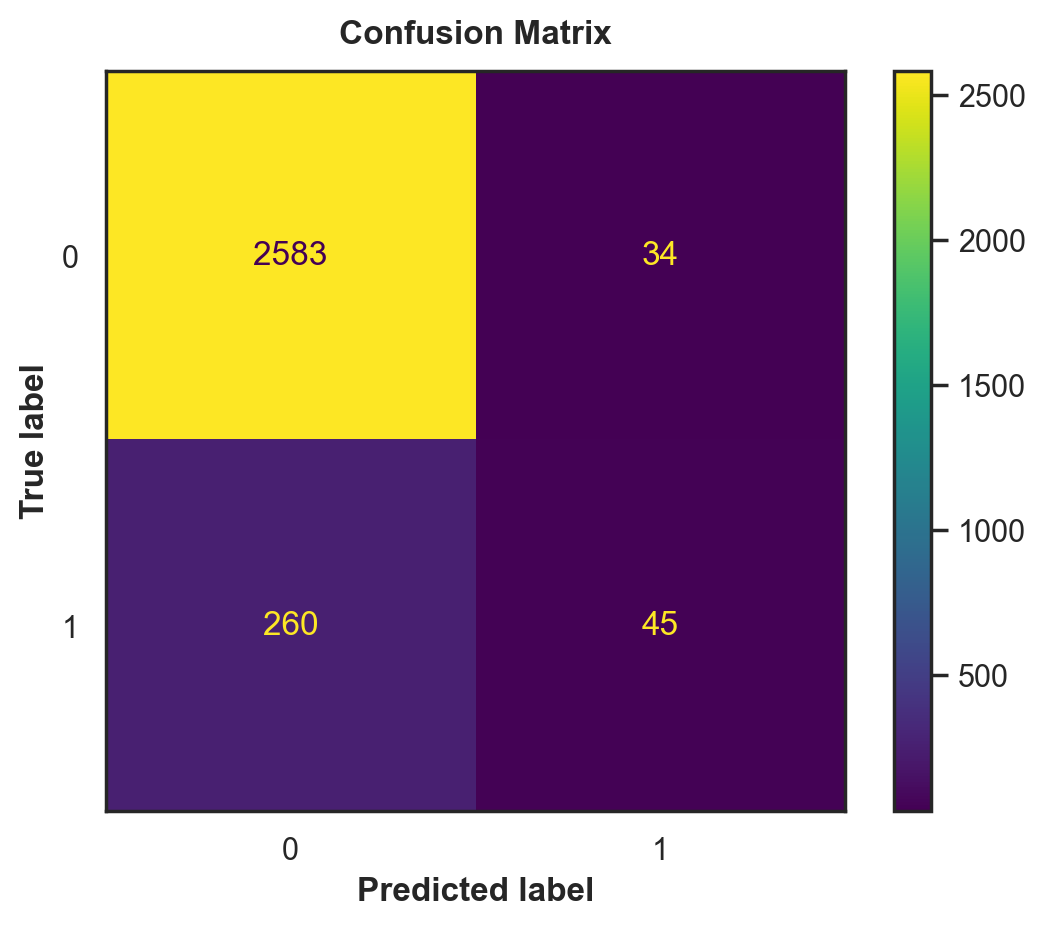

In [52]:
pipeline_SMOTE.plot_confusion_matrix()  # Plot the confusion matrix


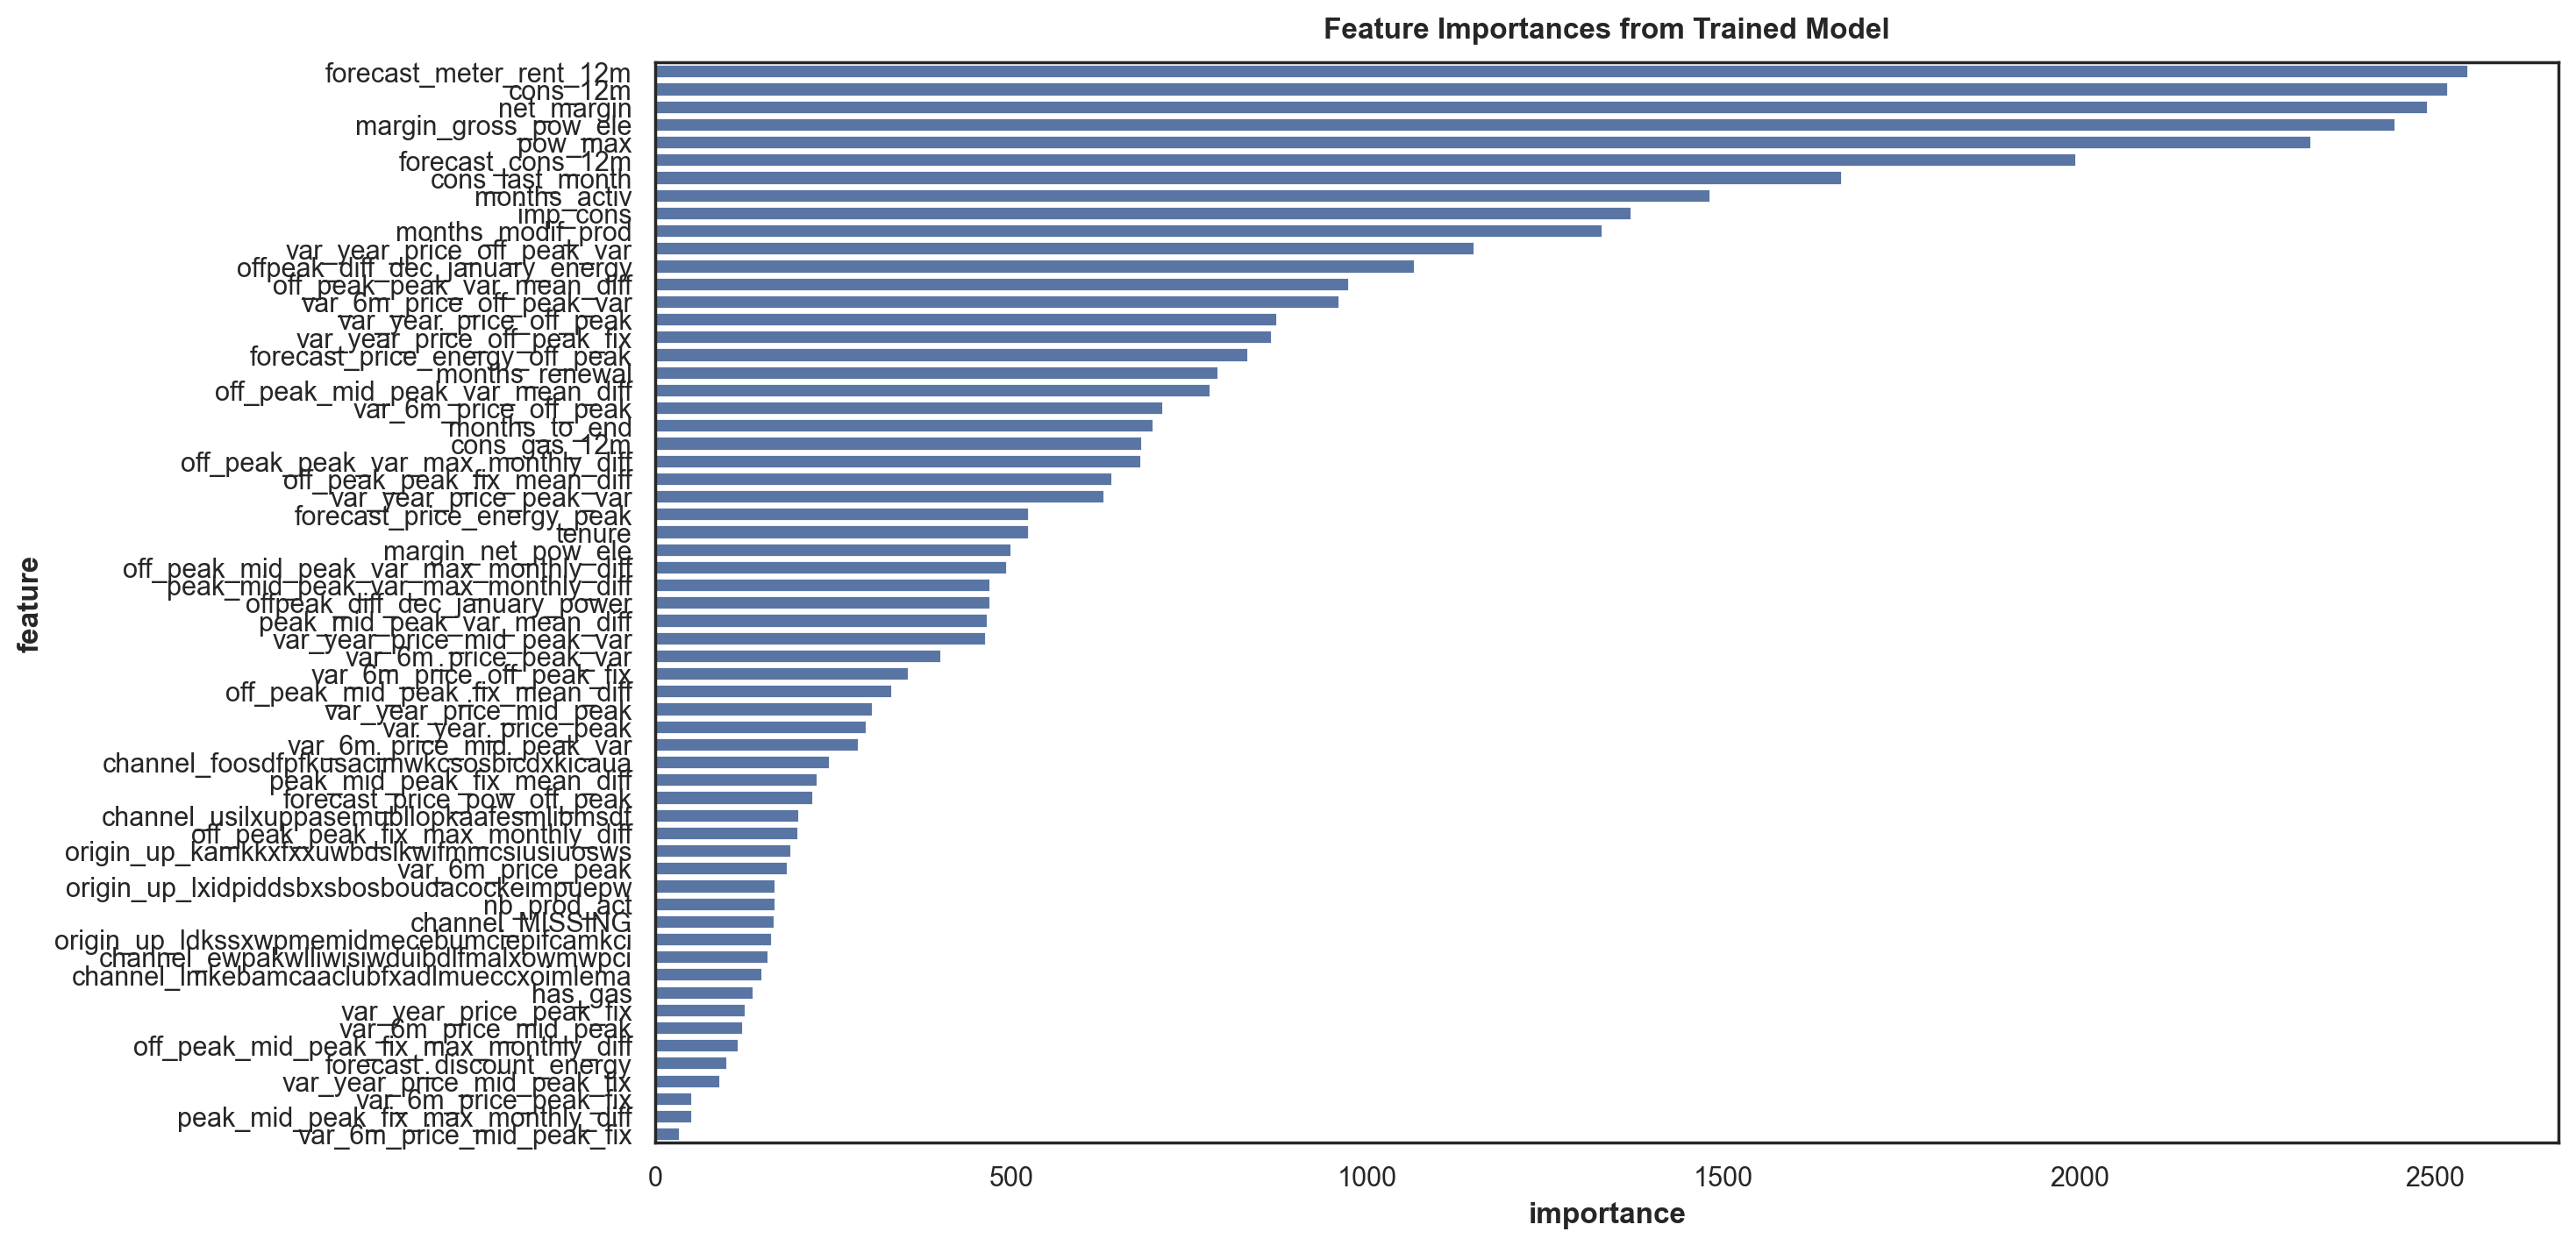

In [53]:
pipeline_SMOTE.visualize_study()

In [60]:
import optuna
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from catboost import CatBoostClassifier, Pool

class ChurnPredictionPipelineCatBoost_SMOTE:
    def __init__(self, df, target_col, test_size=0.2, random_state=42):
        """
        Initialize the pipeline with the dataset and target column.
        """
        self.df = df
        self.target_col = target_col
        self.test_size = test_size
        self.random_state = random_state
        self.X_train, self.X_test, self.y_train, self.y_test = self._prepare_data()
        self.study = None
        self.final_model = None

    def _prepare_data(self):
        """
        Prepare the training and test sets and apply SMOTE for oversampling the minority class.
        """
        X = self.df.drop(columns=[self.target_col, 'id']) if 'id' in self.df.columns.tolist() else self.df.drop(columns=[self.target_col])
        y = self.df[self.target_col]
        
        # Split the data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)

        # # Apply SMOTE to the training set to balance the classes
        # smote = SMOTE(random_state=self.random_state)
        # X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

        # Return the resampled training set and the original test set
        # return X_train_resampled, X_test, y_train_resampled, y_test
        return X_train, X_test, y_train, y_test

    def objective(self, trial):
        """
        Objective function for Optuna to optimize hyperparameters.
        """
        n_estimators = trial.suggest_int("n_estimators", 150, 400)
        max_depth = trial.suggest_int("max_depth", 5, 15, log=True)
        learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1, log=True)
        depth = trial.suggest_int("depth", 5, 15)
        l2_leaf_reg = trial.suggest_float("l2_leaf_reg", 1, 10)
        subsample = trial.suggest_float("subsample", 0.7, 1.0)
        colsample_bylevel = trial.suggest_float("colsample_bylevel", 0.7, 1.0)

        # Instantiate CatBoost model with suggested hyperparameters
        model = CatBoostClassifier(
            iterations=n_estimators,
            depth=depth,
            learning_rate=learning_rate,
            l2_leaf_reg=l2_leaf_reg,
            subsample=subsample,
            colsample_bylevel=colsample_bylevel,
            random_state=self.random_state,
            verbose=0,  # Suppress output during training
            class_weights=[1, 5]  # Adjust class weights to handle imbalance
        )

        # Perform cross-validation and return the mean accuracy score
        score = cross_val_score(model, self.X_train, self.y_train, cv=5, scoring="accuracy").mean()
        return score

    def optimize(self, n_trials=50):
        """
        Run the Optuna optimization.
        """
        self.study = optuna.create_study(direction="maximize")
        self.study.optimize(self.objective, n_trials=n_trials)
        print("Best hyperparameters:", self.study.best_params)

    def train_final_model(self):
        """
        Train the final model using the best parameters found by Optuna.
        """
        if self.study is None:
            raise ValueError("The study has not been optimized yet. Run the `optimize` method first.")
        
        best_params = self.study.best_params
        self.final_model = CatBoostClassifier(
            iterations=best_params["n_estimators"],
            depth=best_params["depth"],
            learning_rate=best_params["learning_rate"],
            l2_leaf_reg=best_params["l2_leaf_reg"],
            subsample=best_params["subsample"],
            colsample_bylevel=best_params["colsample_bylevel"],
            random_state=self.random_state,
            verbose=0,
            class_weights=[1, 5]  # Handle class imbalance
        )
        self.final_model.fit(self.X_train, self.y_train)

    def evaluate_model(self):
        """
        Evaluate the trained model on the test set and print the accuracy and additional metrics.
        """
        y_pred = self.final_model.predict(self.X_test)
        accuracy = accuracy_score(self.y_test, y_pred)
        print("Test set accuracy:", accuracy)

        # Display classification report
        print("Classification Report:")
        print(classification_report(self.y_test, y_pred))

        # Display precision-recall and ROC curves
        from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, roc_curve
        import matplotlib.pyplot as plt
        import numpy as np

        # Precision-recall curve
        precision, recall, _ = precision_recall_curve(self.y_test, self.final_model.predict_proba(self.X_test)[:, 1])
        pr_auc = auc(recall, precision)
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()
        plt.show()

        # ROC curve
        fpr, tpr, _ = roc_curve(self.y_test, self.final_model.predict_proba(self.X_test)[:, 1])
        roc_auc = roc_auc_score(self.y_test, self.final_model.predict_proba(self.X_test)[:, 1])
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()

    def plot_confusion_matrix(self):
        """
        Plot the confusion matrix for the model's performance on the test set.
        """
        sns.set_theme(context='notebook', style='white')
        if self.final_model is None:
            raise ValueError("The final model has not been trained yet. Run the `train_final_model` method first.")
        
        y_pred = self.final_model.predict(self.X_test)
        cm = confusion_matrix(self.y_test, y_pred)
        
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.final_model.classes_)
        disp.plot(cmap='viridis', values_format='d')
        plt.title('Confusion Matrix')
        plt.show()

    def visualize_study(self):
        """
        Visualize the optimization study to understand hyperparameter distributions and results.
        """
        if self.study is None:
            raise ValueError("The study has not been optimized yet. Run the `optimize` method first.")
        
        # Plot the optimization history (value of the objective function over trials)
        optuna.visualization.plot_optimization_history(self.study).show()
        # Plot the parameter importance
        optuna.visualization.plot_param_importances(self.study).show()

        # Show feature importances if the model is trained
        if self.final_model is not None:
            importances = self.final_model.get_feature_importance()
            feature_importances_df = pd.DataFrame({
                'feature': self.X_train.columns,
                'importance': importances
            }).sort_values(by='importance', ascending=False)

            plt.figure(figsize=(14, 8))
            sns.barplot(x='importance', y='feature', data=feature_importances_df)
            plt.title('Feature Importances from Trained Model')
            plt.show()


ModuleNotFoundError: No module named 'catboost'

In [59]:
!pip install catboost

  Using cached catboost-1.2.7.tar.gz (71.5 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'


  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [145 lines of output]
        Using cached setuptools-75.6.0-py3-none-any.whl.metadata (6.7 kB)
        Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
        Using cached jupyterlab-3.6.8-py3-none-any.whl.metadata (12 kB)
        Using cached conan-1.65.0.tar.gz (789 kB)
        Installing build dependencies: started
        Installing build dependencies: finished with status 'done'
        Getting requirements to build wheel: started
        Getting requirements to build wheel: finished with status 'done'
        Preparing metadata (pyproject.toml): started
        Preparing metadata (pyproject.toml): finished with status 'done'
        Using cached ipython-8.30.0-py3-none-any.whl.metadata (4.9 kB)
        Using cached packaging-24.2-py3-none-any.whl.metadata (3.2 kB)
        Using cached tornado-6.4.2-cp38-abi3-win_amd64.whl.metadat